In [13]:
from config_path import add_to_sys_path
add_to_sys_path()  # Call the function to add path

import numpy as np
from sympy.physics.wigner import wigner_3j,wigner_6j
from qutip import *
import sympy as sy
from numpy import linalg as LA
from IPython.display import Latex,display
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_palette('bright')
sns.set_style('ticks')
from Energy_Levels import MoleculeLevels
from Energy_Levels import branching_ratios, Calculate_TDMs,Calculate_TDM_evecs
from functools import partial
np.set_printoptions(precision=5, suppress=True)
from tabulate import tabulate
from matplotlib.collections import LineCollection
from CPT_Sims import *
import ujson as uj

In [15]:
%matplotlib qt

In [3]:
X010 = MoleculeLevels.initialize_state('YbOH','174','X010',[1],M_values = 'all',I=[0,1/2],S=1/2,round=8,P_values=[1/2,3/2])
A000 = MoleculeLevels.initialize_state('YbOH','174','A000',[1,2],M_values = 'all',I=[0,1/2],S=1/2,round=8,P_values=[1/2])

In [8]:
#evals, N=1,2,3, with no hyperfine, no M! array([320.15256, 320.15318, 320.15407, 320.15525, 321.12791, 321.12994, 321.13336, 321.13634, 322.59192, 322.59617, 322.60058, 322.60615])
#Egamma N=1, P=- is 45.3 MHz
#Egamma N=1, P=+ is 62.1 MHz

In [16]:
X010.parameters

{'mu_B': 1.399624494,
 'g_S': 2.07,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 7328.644,
 'Gamma_SR': -88.66,
 'Gamma_Prime': 17.38,
 'bF': 4.08,
 'c': 3.41,
 'q_lD': -12.03,
 'p_lD': -11.3,
 'muE': 1.0823357999999998,
 'Origin': 319.90901,
 'g_l': 0.0}

In [46]:
A000.parameters

{'mu_B': 1.399624494,
 'g_S': 1.86,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 7586.3,
 'ASO': 40471981.8,
 'a': 0.01,
 'bF': 0.06985,
 'c': 0.1799,
 'p+2q': -13133.0,
 'q': 0,
 'D': 0.006952,
 'p2q_D': 0.1139,
 'g_lp': -0.724,
 'muE': 0.21646716}

In [50]:
A000.update_params({'a':0})
A000.parameters

{'mu_B': 1.399624494,
 'g_S': 1.86,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 7586.3,
 'ASO': 40471981.8,
 'a': 0,
 'bF': 0.06985,
 'c': 0.1799,
 'p+2q': -13133.0,
 'q': 0,
 'D': 0.006952,
 'p2q_D': 0.1139,
 'g_lp': -0.724,
 'muE': 0.21646716}

In [4]:
def l2s(inputlist):
      """
      Convert a flatten list to a list of slices:
      test = [0,2,3,4,5,6,12,99,100,101,102,13,14,18,19,20,25]
      list_to_slices(test)
      -> [(0, 0), (2, 6), (12, 14), (18, 20), (25, 25), (99, 102)]
      """
      inputlist.sort()
      pointers = np.where(np.diff(inputlist) > 1)[0]
      pointers = zip(np.r_[0, pointers+1], np.r_[pointers, len(inputlist)-1])
      slices = [(inputlist[i], inputlist[j]+1) for i, j in pointers]
      return slices

# generate n level basis
def q_basis(n):
    q_basis = []
    for i in range(n):
        q_basis.append(basis(n,i))
    return q_basis

def q_dict(q_basis, q_str):
    q_dict = {qs: qb for qs,qb in zip(q_str, q_basis)}
    return q_dict

def q_ops(q_basis):
    n = len(q_basis)
    q_ops = np.zeros((n,n)).tolist()
    for i in range(n):
        for j in range(n):
            q_ops[i][j] = q_basis[i]*q_basis[j].dag()
    return q_ops

def exp_osc(t,args):
    w = args['w']
    return np.exp(1j*w*t)

def exp_conj(t,args):
    w = args['w']
    return np.exp(-1j*w*t)

def linear_ramp(t,args):
    m = args['slope']
    b = args['start']
    stop = args['stop']
    y = m*t+b
    if y>stop:
        return 0
    else:
        return y
    
def on_off(t,args):
    on = args['on']
    off = args['off']
    if t>on and t<off:
        return 1
    else:
        return 0

def exp_onoff(t,args):
    w = args['w']
    on = args['on']
    off = args['off']
    exp = np.exp(1j*w*t)
    if t>on and t<off:
        return 1*exp
    else:
        return 0

def expconj_onoff(t,args):
    w = args['w']
    on = args['on']
    off = args['off']
    exp = np.exp(-1j*w*t)
    if t>on and t<off:
        return 1*exp
    else:
        return 0
    
def chop_func(array,tol):
    copy = np.copy(array)
    copy[abs(copy) < tol] = 0
    return copy

def get_json_data(file_path,numpy=False,ujson=True):
    if '.json' not in file_path:
        file_path+='.json'
    with open(file_path, 'r') as f:
        if ujson:
            data = uj.load(f)
        else:
            data = json.load(f)
    if numpy:
        data = np.array(data)
    return data

def save_json_data(data,file_path,ujson=True):
    if type(data) is np.ndarray:
        data_save = data.tolist()
    else:
        data_save=data
    if '.json' not in file_path:
        file_path+='.json'
    with open(file_path,'w') as f:
        if ujson:
            uj.dump(data_save,f)
        else:
            json.dump(data_save,f)
    print('Data saved to', file_path)
    


In [5]:
# g_all = X010.select_q({'N':2},parity='-')
# allgvals = np.copy(X010.evals0[g_all])
# zero = min(allgvals)
# allgvals -= zero
# # idx = X010.select_q({'N':2,'J':3/2},parity='-')
# # E_Hyp = np.mean(X010.evals0[X010.select_q({'N':2,'J':5/2},parity='-')]) - zero
# # idx = X010.select_q({'N':2,'J':3/2},parity='+')
# # E_Hyp = np.mean(X010.evals0[X010.select_q({'N':2,'J':5/2},parity='+')]) - zero

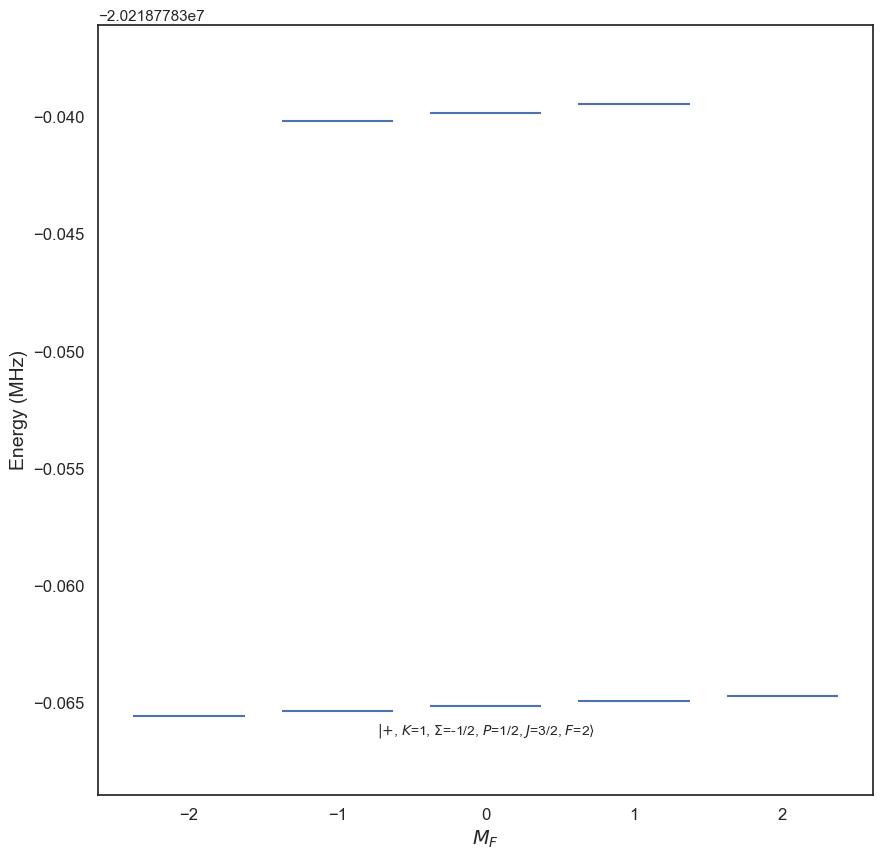

In [15]:
A000.display_levels(0,1e-3,'J',parity=True,idx=A000.select_q({'J':3/2},parity='+'));

In [16]:
help(X010.display_levels)

Help on method display_levels in module Energy_Levels:

display_levels(Ez, Bz, pattern_q, idx=None, label=True, label_off=0.03, parity=False, pretty=True, thickness=1.5, label_q=None, width=0.75, ket_size=10, label_size=14, figsize=(10, 10), ylim=None, deltaE_label=3000, alt_label=False) method of Energy_Levels.MoleculeLevels instance



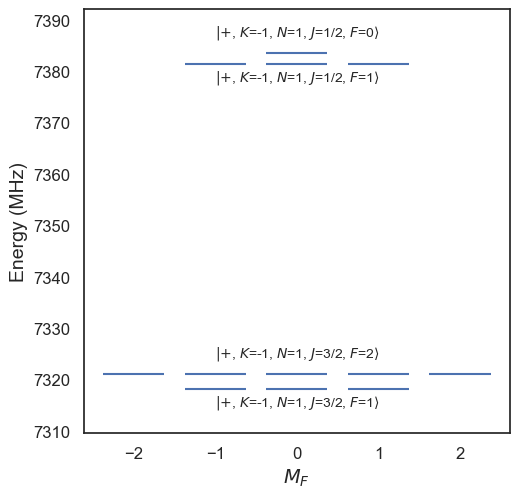

In [17]:
fig = X010.display_levels(0,1e-3,'F',idx = X010.select_q({'N':1,'J':[1/2,3/2]},parity='+'),parity=True,figsize=(5.5,5.5),alt_label=True,label_off=0.05)
fig.savefig('Testfig.pdf',bbox_inches='tight')

In [5]:
E0=0
B0=1e-3
X010.eigensystem(E0,B0)
A000.eigensystem(E0,B0)
chop1 = 1e-4
chop2 = 1e-4
TDM0 = chop_func(Calculate_TDMs(0,X010,A000,E0,B0,[0],chop=chop1),chop2)
TDMp = chop_func(Calculate_TDMs(1,X010,A000,E0,B0,[0],chop=chop1),chop2)
TDMm = chop_func(Calculate_TDMs(-1,X010,A000,E0,B0,[0],chop=chop1),chop2)
TDM_total = TDM0 - TDMp - TDMm # not used
TDMx = -1/np.sqrt(2)*(TDMp - TDMm)

g_all = X010.select_q({'N':1},parity='+')
e_all = A000.select_q({'J':3/2},parity='+')
gs = l2s(g_all)[0]
es = l2s(e_all)[0]
gl = np.arange(*gs)
el = np.arange(*es)
e_labels = [A000.gen_state_str(i,thresh=0.2,single=True,parity=True,show_coeff=False, label_q=['J','F','M']) for i in e_all][::-1]
g_labels = [X010.gen_state_str(i,thresh=0.2,single=True,parity=True,show_coeff=False, label_q=['N','J','F','M']) for i in g_all][::-1]
all_labels = [*e_labels,*g_labels,'dark']

Successfully converted eigenvectors from bBJ to aBJ
Successfully converted eigenvectors from bBJ to aBJ
Successfully converted eigenvectors from bBJ to aBJ


In [62]:
X010.display_levels(E0,B0,'F',parity=True);

In [20]:
all_labels

['$|+,J=\\frac{3}{2},F=1,M=1\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=1,M=0\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=1,M=-1\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=2\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=1\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=0\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=-1\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=-2\\rangle\\,$',
 '$|+,N=1,J=\\frac{1}{2},F=0,M=0\\rangle\\,$',
 '$|+,N=1,J=\\frac{1}{2},F=1,M=-1\\rangle\\,$',
 '$|+,N=1,J=\\frac{1}{2},F=1,M=0\\rangle\\,$',
 '$|+,N=1,J=\\frac{1}{2},F=1,M=1\\rangle\\,$',
 '$|+,N=1,J=\\frac{3}{2},F=2,M=2\\rangle\\,$',
 '$|+,N=1,J=\\frac{3}{2},F=2,M=1\\rangle\\,$',
 '$|+,N=1,J=\\frac{3}{2},F=2,M=0\\rangle\\,$',
 '$|+,N=1,J=\\frac{3}{2},F=2,M=-1\\rangle\\,$',
 '$|+,N=1,J=\\frac{3}{2},F=2,M=-2\\rangle\\,$',
 '$|+,N=1,J=\\frac{3}{2},F=1,M=1\\rangle\\,$',
 '$|+,N=1,J=\\frac{3}{2},F=1,M=0\\rangle\\,$',
 '$|+,N=1,J=\\frac{3}{2},F=1,M=-1\\rangle\\,$',
 'dark']

In [40]:
X010.select_q({'N':1, 'J':3/2,'M':2},parity='+')

array([15])

In [41]:
M2 = X010.select_q({'N':1, 'J':3/2,'F':2,'M':2},parity='+')[0]
M1 = X010.select_q({'N':1, 'J':1/2,'F':1,'M':1},parity='+')[0]

In [36]:
Bz = np.linspace(1e-3,2,10001)
X010.ZeemanMap(Bz,0,plot=True,idx=[M2,M1])

In [37]:
X010.g_eff_Map('B',step=1e-5)

array([[-0.82379,  0.     ,  0.82236, ...,  0.     ,  0.31651,  0.00071],
       [-0.82308,  0.     ,  0.82308, ...,  0.     ,  0.31651,  0.00071],
       [-0.82308,  0.     ,  0.82308, ...,  0.     ,  0.31651,  0.     ],
       ...,
       [-0.96026, -0.32795,  0.45798, ..., -0.17648,  0.40154,  0.34223],
       [-0.96026, -0.32866,  0.45798, ..., -0.17648,  0.40154,  0.34223],
       [-0.96026, -0.32795,  0.45727, ..., -0.17648,  0.40082,  0.34223]])

In [41]:
m_g = np.array([X010.g_eff_B.T[M2], X010.g_eff_B.T[M1]])

In [42]:
m_g.T[Bz.searchsorted(0)]

array([ 1.03456, -0.29365])

In [44]:
m_g.T[Bz.searchsorted(0)][0] - m_g.T[Bz.searchsorted(0)][1]

1.3517911470798967

In [43]:
m_g.T[Bz.searchsorted(0)]

array([ 1.03528, -0.31651])

In [30]:
X010.write_state(X010.select_q({'N':1, 'J':3/2,'M':2},parity='+')[0])

E = 7321.83013901 MHz

 0.70710678 |K=-1,N=1.0,J=1.5,F=2.0,M=2.0> 

 0.70710678 |K=1,N=1.0,J=1.5,F=2.0,M=2.0> 



In [6]:
allgvals = np.copy(X010.evals0[g_all])
# zero = min(allgvals)
zero = np.mean(X010.evals0[X010.select_q({'N':1,'J':3/2},parity='+')])
allgvals -= zero
idx = X010.select_q({'N':1,'J':1/2},parity='+')
E_Hyp = np.mean(X010.evals0[X010.select_q({'N':1,'J':3/2},parity='+')]) - zero
# idx = X010.select_q({'N':2,'J':3/2},parity='+')
# E_Hyp = np.mean(X010.evals0[X010.select_q({'N':2,'J':5/2},parity='+')]) - zero
# E_SR = min(X010.evals0[idx]-zero)
# for i, gv in enumerate(allgvals):
#     if i in idx:
#         minE = min(X010.evals0[idx]-zero)
#         allgvals[i] -= minE
gvals = allgvals
evals = A000.evals0[e_all]
evals-=evals[0]
e_hyp_offset =evals.mean()
dark = np.array([0])
gvals-=e_hyp_offset
evals-=e_hyp_offset

size = gvals.size+evals.size+dark.size
H0 = np.zeros((size,size))
diag = np.diag_indices(size)
H0[diag] = np.round(np.concatenate((evals[::-1],gvals[::-1],dark)),5)
# for i,label in enumerate(all_labels):
#     if 'F=0' in label:
#         H0[i][i]+=2.5
        

TDM_Z = TDM0[:,g_all][e_all,:][::-1,::-1]
TDM_X = TDMx[:,g_all][e_all,:][::-1,::-1]
TDM_p = TDMp[:,g_all][e_all,:][::-1,::-1]
TDM_m = TDMm[:,g_all][e_all,:][::-1,::-1]
# TDM_BR = TDM_total[:,g_all][e_all,:][::-1,::-1]

Hoff_Z = np.zeros((size,size))
Hoff_X = np.zeros((size,size))
BR0 = np.zeros((size,size))
BRp = np.zeros((size,size))
BRm = np.zeros((size,size))
for i in range(evals.size):
    for j in range(gvals.size):
        _tdmz = TDM_Z[i,j]
        _tdmx = TDM_X[i,j]
        _tdmbrp = TDM_p[i,j]
        _tdmbrm = TDM_m[i,j]
        Hoff_Z[i,evals.size+j] = _tdmz
        Hoff_X[i,evals.size+j] = _tdmx
        BR0[i,evals.size+j] = _tdmz
        BRp[i,evals.size+j] = _tdmbrp
        BRp[i,evals.size+j] = _tdmbrm
BR0*=np.sqrt(0.8944)
BRp*=np.sqrt(0.8944)
BRm*=np.sqrt(0.8944)
Hoff_Z*=np.sqrt(0.8944)
Hoff_X*=np.sqrt(0.8944)
for i in range(evals.size):
    BR0[i,-1]+= np.sqrt(1/3-(BR0[i,:]**2).sum())
    BRm[i,-1]+= np.sqrt(1/3-(BRm[i,:]**2).sum())
    BRp[i,-1]+= np.sqrt(1/3-(BRp[i,:]**2).sum())
    
qb = q_basis(size)
qd = q_dict(qb,all_labels)
qops = q_ops(qb)

    #old code
    # dipole = 5.24 #Debye
    # dipole*= 0.503412 #convert Debye to MHz/(V/cm)
    # Isat = 5 #mW/cm^2
    # E_X = np.sqrt(s_X*Isat*0.753460627) #convert mW/cm^2 to (V/cm)^2 using 2/(c*eps_0)
    # E_Z = np.sqrt(s_Z*Isat*0.753460627)
    # Rabi_X = dipole*E_X
    # Rabi_Z = dipole*E_Z
    
J32_states = [qops[i][i] for i,label in enumerate(all_labels) if 'N=1,J=\\frac{3}{2}' in label]
J12_states = [qops[i][i] for i,label in enumerate(all_labels) if 'N=1,J=\\frac{1}{2}' in label]
J32_stretched = [qops[i][i] for i,label in enumerate(all_labels) if 'N=1,J=\\frac{3}{2}' in label and ('M=2' in label or 'M=-2' in label)]
J32_middle = [_op for _op in J32_states if _op not in J32_stretched]
J32_zero = [qops[i][i] for i,label in enumerate(all_labels) if 'N=1,J=\\frac{3}{2}' in label and 'M=0' in label]
# J32_states = [qops[i][i] for i,label in enumerate(all_labels) if 'N=2,J=\\frac{5}{2}' in label]
# J12_states = [qops[i][i] for i,label in enumerate(all_labels) if 'N=2,J=\\frac{3}{2}' in label]
e_states = [qops[i][i] for i,label in enumerate(all_labels) if '+,J=\\frac{3}{2}' in label]
dark_state = [qops[-1][-1]]
rho0 = sum(J32_states)/(len(J32_states))
# rho0 = sum(J32_stretched)/(len(J32_stretched))
# rho0 = J32_stretched[0]
matrix_info = [H0,Hoff_Z,Hoff_X,BR0,BRp,BRm,rho0]

In [64]:
two_photon_array = np.arange(58,68,0.05)
# two_photon_array = np.arange(59,63,0.05)

sig_weight = 15# 2.5 for pre aom fix, 15 for post aom fix
center = 60
weighting = np.exp(-(two_photon_array-center)**2/(2*(sig_weight)**2))

# extraleft1 = np.arange(-190,-170,5)
# fineleft = np.arange(-170,-160,1)
# extraleft2 = np.arange(-160,-100,5)
# # extraright = np.arange(10,70,5)
# two_photon_array = np.concatenate((extraleft1,fineleft,extraleft2,two_photon_array))
# one_photon_array = np.arange(-35,35,0.1)
# two_photon_array = np.arange(-10,10,0.1)
s_array = np.arange(1,100,2)
# s_array = np.logspace(-1,3)
state_groups = [e_states,J12_states,J32_states,dark_state]
#,J32_stretched,J32_middle,[J32_zero[0]],[J32_zero[1]]]
# mesh = np.array(np.meshgrid(two_photon_array,s_array,indexing='ij'))

In [134]:
# sim_args = prep_sim(matrix_info,state_groups,qops,qd,pol='XZ',s_X=0.5,s_Z=0.5,one_photon=0*-1000, e_decohere_rate=2*2*np.pi,g_decohere_rate=0.01*2*np.pi, decay_rate=1/0.02, time = np.linspace(0,6,5000))
sim_args = prep_sim_1d_weighted(matrix_info,state_groups,qops,qd,s_X=220,s_Z=220,one_photon=-1000, e_decohere_rate=0.05*2*np.pi,g_decohere_rate=0.05*2*np.pi, decay_rate=1/0.02, time = np.linspace(0,6,5000))
#good params: sx0.5, sz10, edec=10

In [135]:
# res_1d = mp_cpt_sim(two_photon_array,cpt_sim,*sim_args,tf=5)
# res_1d_ZZ = mp_cpt_sim_1d_weighted(two_photon_array,weighting,cpt_sim_1d_weighted,*sim_args,tf=5,pol='ZZ')
res_1d_XZ = mp_cpt_sim_1d_weighted(two_photon_array,weighting,cpt_sim_1d_weighted,*sim_args,tf=5,pol='XZ')

In [136]:
# res_ZZ = res_1d_ZZ[:,1,-1]
res_XZ = res_1d_XZ[:,1,-1]

In [73]:
plt.figure()
plt.plot(two_photon_array,res_XZ)

In [138]:
freq, fl = get_json_data('2ph_N1p_XZ_tot',numpy=True,ujson=True)
idx = freq<67.5
freq = freq[idx]
fl = fl[idx]

In [151]:
idx

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [176]:
fig=plt.figure(figsize=(5.5,5.5/1.5),constrained_layout=True)
idx = two_photon_array<67
plt.plot(two_photon_array[idx]+0.7,res_XZ[idx],label='Model')
plt.plot(freq,fl-0.045,marker='o',linestyle='None',mfc='white',mew=1.75,label='Data')
plt.legend(loc='best')
plt.ylabel('Fluorescence Signal (arb.)')
plt.xlabel('Two Photon RF (MHz)')
plt.title(r'$\tilde{X}(010)$, $N$=$1^+$ Detuned Raman Transitions, Perpendicular Pol.')
plt.annotate('$2\leftrightarrow 1^+$',(59.1,0.17))
plt.annotate('$2\leftrightarrow 0$',(61.9,0.06))
plt.annotate('$1^-\leftrightarrow 1^+$',(62.7,0.12))
plt.annotate('$1^-\leftrightarrow 0$',(64.8,0.107))
#s220

Text(64.8, 0.107, '$1^-\\leftrightarrow 0$')

In [177]:
fig.savefig(save+'combined_2ph_expt_theory_N1p_perp.svg')
fig.savefig(save+'combined_2ph_expt_theory_N1p_perp.pdf')

In [130]:
plt.rcParams.update({'font.size': 10})
save=r'C:\Users\ajadbaba\Dropbox (Hutzler Lab)\HutzlerLabShared\Personal\ArianJadbabaie\Thesis\Ch5\\'
sns.set_style('ticks')

In [132]:
fig,ax1 = plt.subplots(1,1,constrained_layout=True,figsize=(5.5,5.5/1.5))
ax1.plot(freq,fl-0.045)
ax1.set_ylabel('Fluorescence Signal (arb.)')
ax1.set_xlabel('Two Photon RF (MHz)')
left, bottom, width, height = [0.75, 0.62, 0.22, 0.22]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(two_photon_array[:-15]+0.65,res_XZ[:-15])
# ax2.set_xlabel('RF (MHz)',fontsize=10)
# ax2.set_ylabel('Signal')
ax2.set_title('Theory',fontsize=10)
ax1.annotate('$2\leftrightarrow 1^+$',(59.1,0.17))
ax1.annotate('$2\leftrightarrow 0$',(61.8,0.06))
ax1.annotate('$1^-\leftrightarrow 1^+$',(62.5,0.12))
ax1.annotate('$1^-\leftrightarrow 0$',(65.8,0.05))
ax1.set_title(r'$\tilde{X}(010)$, $N$=$1^+$ Detuned Raman Transitions, Perpendicular Pol.')


Text(0.5, 1.0, '$\\tilde{X}(010)$, $N$=$1^+$ Detuned Raman Transitions, Perpendicular Pol.')

In [133]:
# fig.savefig(save+'2ph_expt_theory_N1p_perp.svg')
# fig.savefig(save+'2ph_expt_theory_N1p_perp.pdf')

In [413]:
freqZZ,flZZ = get_json_data('ZZ_N1p_CPT_X010_freq_fluor',numpy=True,ujson=True)
freqXZ,flXZ = get_json_data('XZ_N1p_CPT_X010_freq_fluor',numpy=True,ujson=True)

flXZ = flXZ[freqXZ<=70]
freqXZ = freqXZ[freqXZ<=70]
# [[x,xstd],[y,ystd]] = get_json_data('N1p_CPT_X010_freq_fluor_errorbars',numpy=True,ujson=True)

In [429]:
fig = plt.figure(figsize=(5.5,5.5/1.5),constrained_layout=True)
plt.plot(two_photon_array,rescale2(res_ZZ), label='Model')
plt.plot(freqZZ,rescale2(flZZ),'.',mfc='white',mew=1.5,label='Data')
plt.title(r'$N$=$1^+ \leftrightarrow J^\prime$=$3/2^-$ CPT, Parallel Polarizations')
plt.xlabel('Two Photon RF Frequency (MHz)')
plt.ylabel('Signal (arb. units)')
plt.legend(loc='best')

In [430]:
# fig.savefig(save+'ZZ_N1p_CPT_exp_theory.svg')
# fig.savefig(save+'ZZ_N1p_CPT_exp_theory.pdf')

In [431]:
fig = plt.figure(figsize=(5.5,5.5/1.5),constrained_layout=True)
plt.plot(two_photon_array,rescale2(res_XZ), label='Model')
plt.plot(freqXZ,rescale2(flXZ),'.',mfc='white',mew=1.5,label='Data')
plt.title(r'$N$=$1^+ \leftrightarrow J^\prime$=$3/2^-$ CPT, Perpendicular Polarizations')
plt.xlabel('Two Photon RF Frequency (MHz)')
plt.ylabel('Signal (arb. units)')
plt.legend(loc='best')

In [432]:
fig.savefig(save+'XZ_N1p_CPT_exp_theory.svg')
fig.savefig(save+'XZ_N1p_CPT_exp_theory.pdf')

In [442]:
%matplotlib inline

Text(0.05, 0.05, '(b)')

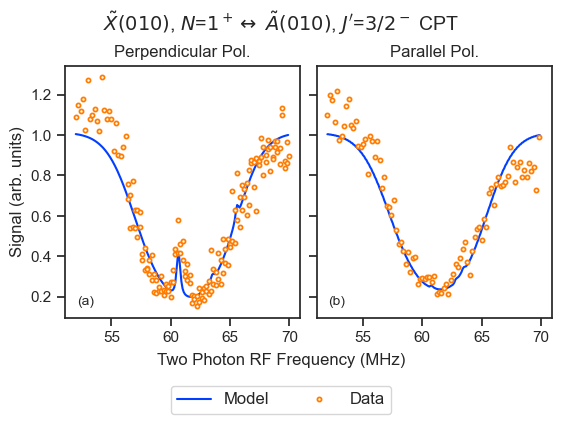

In [446]:
fig,axes = plt.subplots(1,2,figsize=(5.5,5.5/1.5),constrained_layout=True,sharey=True,sharex=True)
axes[1].plot(two_photon_array,rescale2(res_ZZ), label='Model')
axes[1].plot(freqZZ,rescale2(flZZ),'.',mfc='white',mew=1.25,label='Data')

axes[0].plot(two_photon_array,rescale2(res_XZ), label='Model')
axes[0].plot(freqXZ,rescale2(flXZ),'.',mfc='white',mew=1.25,label='Data')
axes[0].set_title('Perpendicular Pol.')
axes[1].set_title('Parallel Pol.')
# axes[1].plot(two_photon_array,j12/0.2)
fig.supxlabel('Two Photon RF Frequency (MHz)',fontsize=12)
axes[0].set_ylabel('Signal (arb. units)',fontsize=12)
title = plt.suptitle(r'$\tilde{X}(010)$, $N$=$1^+ \leftrightarrow$ $\tilde{A}(010)$, $J^\prime$=$3/2^-$ CPT',fontsize=14)
handles,labels = axes[0].get_legend_handles_labels()
lgd=plt.figlegend(handles,labels,bbox_to_anchor=(0.5,-0.075), loc='center', ncol=2,prop=dict(size=12))
axes[0].annotate('(a)',(0.05,0.05),xycoords='axes fraction')
axes[1].annotate('(b)',(0.05,0.05),xycoords='axes fraction')

In [447]:
fig.savefig(save+'Combined_N1p_CPT_exp_theory.svg',bbox_inches='tight',bbox_extra_artists=(lgd,title))
fig.savefig(save+'Combined_N1p_CPT_exp_theory.pdf',bbox_inches='tight',bbox_extra_artists=(lgd,title))

In [406]:
plt.figure(figsize=(12,8))
plt.title('J=1/2 population remaining',fontsize=20)
plt.xlabel('Two Photon Detuning Relative to F=1, J=1/2', fontsize=16)
plt.ylabel('Population',fontsize=16)
j12 = res_1d[:,1,-1]
rescale = lambda x : (x - x.min())/((np.mean(x[:5])+np.mean(x[-5:]))/2)
rescale2 = lambda x : (x)/((np.mean(x[:5])+np.mean(x[-5:]))/2)
plt.plot(two_photon_array,rescale(j12), label='j12')
plt.plot(freq,rescale(fl))
plt.figure()
plt.plot(two_photon_array,rescale2(j12), label='j12')
plt.plot(freq,rescale2(fl))
# plt.plot(two_photon_array,res_1d[:,2,-1], label='j32')
# plt.plot(two_photon_array,res_1d[:,1,-1]+res_array[:,2,-1],label='sum')
# plt.plot(two_photon_array,res_1d[:,3,-1], label='dark')
# plt.plot(two_photon_array,res_1d[:,0,-1], label='excited')
plt.legend(loc='best')

In [407]:
fig = plt.figure(figsize=(5.5,5.5/1.5),constrained_layout=True)
plt.plot(two_photon_array,rescale2(j12), label='Model')
plt.plot(freq,rescale2(fl),'.',mfc='white',mew=1.5,label='Data')
plt.title(r'$\tilde{X}(010)$, N=$1^+$, Parallel CPT')
plt.xlabel('Two Photon RF Frequency (MHz)')
plt.ylabel('Signal (arb. units)')
plt.legend(loc='best')

In [ ]:
fig.savefig(save+'N1p_CPT_exp_theory.svg')
fig.savefig(save+'N1p_CPT_exp_theory.pdf')

In [394]:
freq,fl = get_json_data('N1p_CPT_X010_freq_fluor',numpy=True,ujson=True)
# fl = fl[freq<=70]
# freq = freq[freq<=70]
[[x,xstd],[y,ystd]] = get_json_data('N1p_CPT_X010_freq_fluor_errorbars',numpy=True,ujson=True)

In [404]:
plt.figure(figsize=(12,8))
plt.title('J=1/2 population remaining',fontsize=20)
plt.xlabel('Two Photon Detuning Relative to F=1, J=1/2', fontsize=16)
plt.ylabel('Population',fontsize=16)
j12 = res_1d[:,1,-1]
rescale = lambda x : (x - x.min())/((np.mean(x[:5])+np.mean(x[-5:]))/2)
rescale2 = lambda x : (x)/((np.mean(x[:5])+np.mean(x[-5:]))/2)
plt.plot(two_photon_array,rescale(j12), label='j12')
plt.plot(freq,rescale(fl))
plt.figure()
plt.plot(two_photon_array,rescale2(j12), label='j12')
plt.plot(freq,rescale2(fl))
# plt.plot(two_photon_array,res_1d[:,2,-1], label='j32')
# plt.plot(two_photon_array,res_1d[:,1,-1]+res_array[:,2,-1],label='sum')
# plt.plot(two_photon_array,res_1d[:,3,-1], label='dark')
# plt.plot(two_photon_array,res_1d[:,0,-1], label='excited')
plt.legend(loc='best')

In [390]:
plt.rcParams.update({'font.size': 10})
save=r'C:\Users\ajadbaba\Dropbox (Hutzler Lab)\HutzlerLabShared\Personal\ArianJadbabaie\Thesis\Ch5\\'
sns.set_style('ticks')

In [391]:
fig = plt.figure(figsize=(5.5,5.5/1.5),constrained_layout=True)
plt.plot(two_photon_array,rescale2(j12), label='Model')
ystd_rescale = ystd/((np.mean(y[:5])+np.mean(y[-5:]))/2)
plt.errorbar(x,rescale2(y),yerr=ystd_rescale,marker='.',mfc='white',mew=1.5,label='Data',linestyle='none')
plt.title(r'$\tilde{X}(010)$, N=$1^+$ CPT')
plt.xlabel('Two Photon RF Frequency (MHz)')
plt.ylabel('Signal (arb. units)')
plt.legend(loc='best')

In [397]:
fig = plt.figure(figsize=(5.5,5.5/1.5),constrained_layout=True)
plt.plot(two_photon_array,rescale2(j12), label='Model')
plt.plot(freq[freq<70],rescale2(fl)[freq<70],'.',mfc='white',mew=1.5,label='Data')
plt.title(r'$\tilde{X}(010)$, N=$1^+$ CPT')
plt.xlabel('Two Photon RF Frequency (MHz)')
plt.ylabel('Signal (arb. units)')
plt.legend(loc='best')

In [398]:
fig.savefig(save+'N1p_CPT_exp_theory.svg')
fig.savefig(save+'N1p_CPT_exp_theory.pdf')

In [292]:
fig,axes = plt.subplots(1,2,figsize=(5.5,5.5/1.5),constrained_layout=True,sharey=True,sharex=True)
axes[0].plot(freq,fl/100)
axes[0].set_title('Data')
axes[1].set_title('Modeling')
axes[1].plot(two_photon_array,j12/0.2)
fig.supxlabel('Two Photon RF Frequency (MHz)',fontsize=12)
axes[0].set_ylabel('Signal (arb. units)',fontsize=12)
plt.suptitle(r'$\tilde{X}(010)$, N=$1^+$ CPT')

Text(0.5, 0.98, '$\\tilde{X}(010)$, N=$1^+$ CPT')

In [167]:
plt.figure(figsize=(12,8))
plt.title('J=1/2 population remaining',fontsize=20)
plt.xlabel('Two Photon Detuning Relative to F=1, J=1/2', fontsize=16)
plt.ylabel('Population',fontsize=16)
submean = lambda x : (x - np.mean(x[:5])+np.mean(x[-5:]))/2)
# submean = lambda x : x
line=2
plt.plot(two_photon_array,submean(res_1d[:,1,-1]), label='j12',linewidth=line)
# plt.plot(two_photon_array,submean(res_1d[:,2,-1]), label='j32',linewidth=line)
plt.plot(two_photon_array,submean(res_1d[:,-4,-1]),color='C3',label='j32 stretched',linewidth=line)
# plt.plot(two_photon_array,submean(res_1d[:,-1,-1]),color='C4',label='j32 0, 2',linewidth=line)
# plt.plot(two_photon_array,submean(res_1d[:,-2,-1]),color='C5',label='j32 0, 1',linewidth=line)
plt.plot(two_photon_array,submean(res_1d[:,-3,-1]),color='C6',label='j32 middle',linewidth=line)

# plt.plot(two_photon_array,submean(res_1d[:,3,-1]), label='dark')
# plt.plot(two_photon_array,submean(res_1d[:,0,-1]), label='excited')
plt.legend(loc='best')

SyntaxError: unmatched ')' (1591557156.py, line 5)

In [25]:
plt.figure(figsize=(12,8))
plt.title('J=1/2 population remaining',fontsize=20)
plt.xlabel('Two Photon Detuning Relative to F=1, J=1/2', fontsize=16)
plt.ylabel('Population',fontsize=16)
plt.plot(two_photon_array,res_1d[:,1,-1], label='j12')
plt.plot(two_photon_array,res_1d[:,2,-1], label='j32')
plt.plot(two_photon_array,res_1d[:,1,-1]+res_1d[:,2,-1],label='sum')
plt.plot(two_photon_array,res_1d[:,3,-1], label='dark')
plt.plot(two_photon_array,res_1d[:,0,-1], label='excited')
plt.legend(loc='best')

In [116]:
two_photon_array[83]

-1.7000000000000295

In [124]:
plt.figure()
plt.plot(res_1d[:,1,:].T)

In [8]:
def prep_sim_local(qops,qd,s_X=1,s_Z=1,one_photon = 0,decohere_rate=0.05*2*np.pi, decay_rate = 1/0.02,time = np.linspace(0,3,5000),pol='XZ'):
    
    Rabi_Z = decay_rate*np.sqrt(1/2*s_Z)/2
    Rabi_X =  decay_rate*np.sqrt(1/2*s_X)/2

    decohere = [np.sqrt(decohere_rate)*qops[i][i] for i in range(len(qops))]
    decay = [np.sqrt(decay_rate)*(Qobj(BR.T)) for BR in [BR0,BRp,BRm]]
    collapse=[*decohere,*decay]
    
    Hd = np.zeros((size,size))
    for i in range(evals.size):
        Hd[i,i]-= one_photon
    if pol == 'XZ':
        H=[Qobj(H0+Hd)*2*np.pi,[Rabi_Z*Qobj(Hoff_Z + Hoff_Z.T),on_off],[Rabi_X*Qobj(Hoff_X),exp_onoff],[Rabi_X*Qobj(Hoff_X.T),expconj_onoff]]
    else:
        H=[Qobj(H0+Hd)*2*np.pi,[Rabi_Z*Qobj(Hoff_Z + Hoff_Z.T),on_off],[Rabi_X*Qobj(Hoff_Z),exp_onoff],[Rabi_X*Qobj(Hoff_Z.T),expconj_onoff]]
    return H, rho0, time, collapse

def cpt_sim_local(two_photon, H,rho0,time,collapse):
    two_photon = two_photon*2*np.pi
    result = mesolve(H,rho0,time,collapse,[sum(e_states),sum(J12_states),sum(J32_states),*dark_state],args={'on':0,'off':3,'w':two_photon+E_SR*2*np.pi})
    return result.expect

In [42]:
local_args = prep_sim_local(qops,qd,one_photon=0,s_X=0,s_Z=1,decohere_rate = 0,time=np.linspace(0,4,5000),pol='XZ')

In [44]:
res_local = cpt_sim_local(0, *local_args)

In [45]:
plt.figure()
plt.plot(np.linspace(0,4,5000),res_local[1])
plt.plot(np.linspace(0,4,5000),res_local[2])

In [9]:
two_photon_array = np.arange(-10,10.1,0.1)
# extraleft1 = np.arange(-190,-170,5)
# fineleft = np.arange(-170,-160,1)
# extraleft2 = np.arange(-160,-100,5)
# # extraright = np.arange(10,70,5)
# two_photon_array = np.concatenate((extraleft1,fineleft,extraleft2,two_photon_array))
# one_photon_array = np.arange(-35,35,0.1)
# two_photon_array = np.arange(-10,10,0.1)
s_array = np.arange(1,100,2)
# s_array = np.logspace(-1,3)
state_groups = [e_states,J12_states,J32_states,dark_state]
# mesh = np.array(np.meshgrid(two_photon_array,s_array,indexing='ij'))

In [10]:
sim_args = prep_sim_1ph(one_photon_array,matrix_info,state_groups,E_SR,qops,qd,pol='XZ',s_X=0,s_Z=1,e_decohere_rate=8*2*np.pi,g_decohere_rate=0.05*2*np.pi, decay_rate=1/0.02, time = np.linspace(0,4,5000))

NameError: name 'one_photon_array' is not defined

In [ ]:
res_1d = mp_cpt_sim_1ph(one_photon_array,0,cpt_sim,*sim_args,tf=3)

In [ ]:
plt.figure(figsize=(12,8))
plt.title('J=1/2 population remaining',fontsize=20)
plt.xlabel('One Photon Detuning Relative to F=1, J=1/2', fontsize=16)
plt.ylabel('Population',fontsize=16)
plt.plot(one_photon_array,res_1d[:,2,-1], label='j12')
# plt.plot(two_photon_array,res_1d[:,2,-1], label='j32')
# plt.plot(two_photon_array,res_1d[:,1,-1]+res_array[:,2,-1],label='sum')
# plt.plot(two_photon_array,res_1d[:,3,-1], label='dark')
# plt.plot(two_photon_array,res_1d[:,0,-1], label='excited')
plt.legend(loc='best')

In [11]:
sim_args = prep_sim(matrix_info,state_groups,E_SR,qops,qd,pol='XZ',s_X=80,s_Z=80,one_photon=-E_Hyp-500, e_decohere_rate=10*2*np.pi,g_decohere_rate=0.05*2*np.pi, decay_rate=1/0.02, time = np.linspace(0,4,5000))

In [12]:
res_1d = mp_cpt_sim(two_photon_array,cpt_sim,*sim_args,tf=3)

In [14]:
plt.figure(figsize=(12,8))
plt.title('J=1/2 population remaining',fontsize=20)
plt.xlabel('Two Photon Detuning Relative to F=1, J=1/2', fontsize=16)
plt.ylabel('Population',fontsize=16)
plt.plot(two_photon_array,res_1d[:,1,-1], label='j12')
# plt.plot(two_photon_array,res_1d[:,2,-1], label='j32')
# plt.plot(two_photon_array,res_1d[:,1,-1]+res_array[:,2,-1],label='sum')
# plt.plot(two_photon_array,res_1d[:,3,-1], label='dark')
# plt.plot(two_photon_array,res_1d[:,0,-1], label='excited')
plt.legend(loc='best')

In [9]:
sim_args2d = prep_sim2d(s_array,matrix_info,state_groups,E_SR,qops,qd,one_photon=-1000, decohere_rate=0.01*2*np.pi, decay_rate=1/0.02, time = np.linspace(0,4,5000))

In [ ]:
res_array = mp_cpt_sim_2d(two_photon_array,s_array,cpt_sim_2d,*sim_args2d,tf=3,pol='XZ')

In [ ]:
res_ZZ = mp_cpt_sim_2d(two_photon_array,s_array,cpt_sim_2d,*sim_args2d,tf=3,pol='ZZ')

In [ ]:
res_copy = np.copy(res_array)

In [127]:
rf_yi = np.array([70,75,80,85,90,95,100,105,110])
rf_yi = rf_yi*2-120
power_yi = np.array([0.1,0.5,1.65,3.1,3.75,3,1.5,0.4,0.1])
power_yi/=power_yi.max()
plt.figure()
plt.plot(rf_yi,power_yi,'o')

from lmfit.models import GaussianModel

gmod = GaussianModel('x')
results_yi = gmod.fit(power_yi,amplitude=1,center=60,sigma=5,x=rf_yi)
plt.plot(rf_yi,gmod.eval(results_yi.params,x=rf_yi))
results_yi

In [128]:
plt.figure()

rf_arian = np.array([87,88,89.5,91,92])
rf_arian = 2*rf_arian - 120
power_arian = np.array([0.1,0.5,1,0.5,0.1])
gmod = GaussianModel('x')
plt.plot(rf_arian,power_arian,'o')
results_arian = gmod.fit(power_arian,amplitude=1,center=60,sigma=5,x=rf_arian)
plt.plot(rf_arian,gmod.eval(results_arian.params,x=rf_arian))
results_arian

In [34]:
res_array.shape

(4550, 4, 5000)

In [35]:
res_copy = np.copy(res_array)

In [36]:
res_copy = res_copy.reshape(len(two_photon_array),len(s_array),len(state_groups),5000)

In [41]:
plt.contourf(*mesh,res_copy[:,:,1,-1])
plt.xlabel('Two Photon Detuning (MHz)')
plt.ylabel('Saturation Parameter')

Text(58.0, 0.5, 'Saturation Parameter')

In [ ]:
np.array(*mesh,sim_args2d[0],dtype='object').shape

In [30]:
39996/101/99

4.0

In [17]:
mesh = np.array(np.meshgrid(two_photon_array,s_array,indexing='ij'))
pairs = np.stack((mesh[0].ravel(),mesh[1].ravel()),axis=1)

In [28]:
pairs.size/(101*99)

2.0

In [23]:
res_array.size/(101*99*5000)

16.0

In [15]:
101*99*4*5000

199980000

In [14]:
res_copy.reshape(len(two_photon_array),len(s_array),

ValueError: cannot reshape array of size 799920000 into shape (101,99)

In [74]:
sim_args = prep_sim(matrix_info,state_groups,E_SR,qops,qd,s_X=100,s_Z=100,one_photon=-500, decohere_rate=0.1*2*np.pi, decay_rate=1/0.02, time = np.linspace(0,4,5000))

NameError: name 'state_groups' is not defined

In [93]:
res_array = mp_cpt_sim(two_photon_array,cpt_sim,*sim_args,tf=3)

In [94]:
plt.figure(figsize=(12,8))
plt.title('J=1/2 population remaining',fontsize=20)
plt.xlabel('Two Photon Detuning Relative to F=1, J=1/2', fontsize=16)
plt.ylabel('Population',fontsize=16)
plt.plot(two_photon_array,res_array[:,1,-1], label='j12')
plt.plot(two_photon_array,res_array[:,2,-1], label='j32')
plt.plot(two_photon_array,res_array[:,1,-1]+res_array[:,2,-1],label='sum')
# plt.plot(two_photon_array,res_array[:,3,-1], label='dark')
# plt.plot(two_photon_array,res_array[:,0,-1], label='excited')
plt.legend(loc='best')

In [47]:
proj_e12 = np.array(sum(e_states)+sum(J12_states))
proj_e32 = np.array(sum(e_states)+sum(J32_states))
proj_j12 = np.array(sum(J12_states))
proj_j32 = np.array(sum(J32_states))
proj_e = np.array(sum(e_states))
proj_g = proj_j12+proj_j32

In [84]:
Htot = np.round(5*J12_states[0]+proj_g@H0@proj_g-(123.545-3.03)*proj_j12+0.2*proj_e12@(Hoff_X+Hoff_X.T)@proj_e12+0.2*proj_e32@(Hoff_Z+Hoff_Z.T)@proj_e32,3)

In [85]:
sy.Matrix(Htot[:-1,:-1])

Matrix([
[     0,      0,      0,      0,     0,      0,     0,      0, -0.047,      0, 0.025,      0,      0, 0.033,      0,      0,     0, 0.094,      0,      0],
[     0,      0,      0,      0,     0,      0,     0,      0,      0,  0.025,     0, -0.025,      0,     0, -0.038,      0,     0,     0,      0,      0],
[     0,      0,      0,      0,     0,      0,     0,      0,  0.047,      0, 0.025,      0,      0,     0,      0, -0.033,     0,     0,      0, -0.094],
[     0,      0,      0,      0,     0,      0,     0,      0,      0,      0,     0, -0.057, -0.113,     0,      0,      0,     0,     0,      0,      0],
[     0,      0,      0,      0,     0,      0,     0,      0,      0,      0,  0.04,      0,      0, 0.057,      0,      0,     0, 0.034,      0,      0],
[     0,      0,      0,      0,     0,      0,     0,      0,      0, -0.023,     0, -0.023,      0,     0,      0,      0,     0,     0, -0.039,      0],
[     0,      0,      0,      0,     0,      0,     0, 

In [86]:
diag = sy.Matrix(Htot[:-1,:-1]).eigenvects()

In [87]:
for i,d in enumerate(diag):
    vec = np.round(np.array(d[2][0],dtype=float),4)
    if abs(vec[:len(e_states)]).max()<0.1:
        print(all_labels[i])
        print(np.round(np.array(d[0],dtype=float),4))
        print(vec)
        print('\n')

$|+,J=\frac{3}{2},F=1,M=1\rangle\,$
3.0354
[[-0.    ]
 [-0.0062]
 [-0.    ]
 [-0.0294]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.0294]
 [ 0.    ]
 [-0.3405]
 [ 0.    ]
 [ 0.3405]
 [ 0.6183]
 [-0.    ]
 [ 0.0435]
 [ 0.    ]
 [ 0.6183]
 [ 0.    ]
 [-0.    ]
 [ 0.    ]]


$|+,J=\frac{3}{2},F=1,M=0\rangle\,$
3.0354
[[ 0.    ]
 [ 0.    ]
 [-0.    ]
 [ 0.0294]
 [-0.    ]
 [ 0.0051]
 [ 0.    ]
 [ 0.0294]
 [ 0.    ]
 [-0.3355]
 [-0.    ]
 [-0.3355]
 [-0.6218]
 [ 0.    ]
 [-0.    ]
 [ 0.    ]
 [ 0.6218]
 [ 0.    ]
 [-0.0001]
 [ 0.    ]]


$|+,J=\frac{3}{2},F=1,M=-1\rangle\,$
3.0308
[[ 0.    ]
 [-0.016 ]
 [-0.    ]
 [ 0.0017]
 [ 0.    ]
 [-0.    ]
 [ 0.    ]
 [-0.0017]
 [ 0.    ]
 [-0.3847]
 [ 0.    ]
 [ 0.3847]
 [-0.2389]
 [ 0.    ]
 [ 0.7679]
 [ 0.    ]
 [-0.2389]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]]


$|+,J=\frac{3}{2},F=2,M=2\rangle\,$
3.0303
[[-0.    ]
 [-0.    ]
 [-0.    ]
 [-0.0008]
 [ 0.    ]
 [ 0.0094]
 [ 0.    ]
 [-0.0008]
 [ 0.    ]
 [-0.6223]
 [-0.    ]
 [-0.6223]
 [ 0.3358]
 [ 0.    ]
 [-0

In [108]:
for d in diag:
    print(d[-1].round(4))

AttributeError: 'list' object has no attribute 'round'

In [32]:
np.searchsorted(two_photon_array,-2.7)

34

In [89]:
sim_args = prep_sim(matrix_info,state_groups,E_SR,qops,qd,s_X=100,s_Z=100,one_photon=-500, decohere_rate=0.2*2*np.pi, decay_rate=1/0.02, time = np.linspace(0,4,5000))
res=cpt_sim(-2.79,*sim_args,tf=3)

In [90]:
plt.figure()
plt.plot(np.linspace(0,4,5000),res[1])

In [52]:
plt.plot(np.linspace(0,4,5000),res[1])

In [54]:
plt.plot(np.linspace(0,4,5000),res[1])

In [56]:
plt.plot(np.linspace(0,4,5000),res[1])

In [43]:
g_labels

['$|-,N=1,J=\\frac{1}{2},F=0,M=0\\rangle\\,$',
 '$|-,N=1,J=\\frac{1}{2},F=1,M=-1\\rangle\\,$',
 '$|-,N=1,J=\\frac{1}{2},F=1,M=0\\rangle\\,$',
 '$|-,N=1,J=\\frac{1}{2},F=1,M=1\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=2,M=2\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=2,M=1\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=2,M=0\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=2,M=-1\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=2,M=-2\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=1,M=1\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=1,M=0\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=1,M=-1\\rangle\\,$']

In [44]:
e_labels

['$|+,J=\\frac{3}{2},F=1,M=1\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=1,M=0\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=1,M=-1\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=2\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=1\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=0\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=-1\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=-2\\rangle\\,$']

In [130]:
#sy.Matrix(Hoff_Z)

In [ ]:
#sy.Matrix(Htot)

In [76]:
# res_array = []
# for two in twophoton_array:
#     res_array.append(cpt_sim(two,*sim_args))
# res_array=np.array(res_array)

In [77]:
plt.figure(figsize=(12,8))
plt.title('J=1/2 population remaining',fontsize=20)
plt.xlabel('Two Photon Detuning Relative to F=1, J=1/2', fontsize=16)
plt.ylabel('Population',fontsize=16)
plt.plot(twophoton_array,res_array[:,-1])

In [279]:
E0=0
B0=1e-6
TDM0 = Calculate_TDMs(0,X010,A000,E0,B0,[-1,1])
TDMp = Calculate_TDMs(1,X010,A000,E0,B0,[-1,1])
TDMm = Calculate_TDMs(-1,X010,A000,E0,B0,[-1,1])
TDM_total = np.round(TDM0 - TDMp - TDMm,5)
TDMx = -1/np.sqrt(2)*(TDMp - TDMm)

Successfully converted eigenvectors from bBJ to aBJ
Successfully converted eigenvectors from bBJ to aBJ
Successfully converted eigenvectors from bBJ to aBJ


In [7]:
fig,ax = plt.subplots(figsize=(10,10),constrained_layout=True)
# ax.set_aspect('equal')
g_all = X010.select_q({'N':1},parity='-')
e_all = A000.select_q({'J':3/2},parity='+')
gs = l2s(g_all)[0]
es = l2s(e_all)[0]
gl = np.arange(*gs)
el = np.arange(*es)
log=False
BR_plot = TDM0 #convert MHz/V/cm to Debye
if log:
    BR_plot=np.log10(BR_plot)
    vmin = -10
    vmax = 0
else:
    vmin=None
    vmax = None
#     log_BR = np.copy(BR0)
#     for i,val1 in enumerate(log_BR):
#         for j,val2 in enumerate(val1):
#             if val2 !=0:
#                 log_BR[i,j] = np.log10(val2)
#     BR_plot = log_BR
mat = ax.matshow(BR_plot[slice(*es),slice(*gs)],cmap=plt.get_cmap('bwr'),vmax = 0.5, vmin = -0.5)
y = np.arange(0,len(el))
x = np.arange(0,len(gl))
ax.set_yticks(y)
ax.set_xticks(x)
y_labels = [A000.gen_state_str(i,thresh=0.2,single=True,parity=True,show_coeff=False, label_q=['J','F','M']) for i in el]
x_labels = [X010.gen_state_str(i,thresh=0.2,single=True,parity=True,show_coeff=False, label_q=['N','J','F','M']) for i in gl]
# x_labels = [X010.gen_state_str(i,thresh=0.3,single=True,parity=False,show_coeff=True, basis='decoupled',label_q=['K','M_N','M_S','M_F'],round=2) for i in N2]
# y_labels = [X010.gen_state_str(i,thresh=0.3,single=True,parity=False,show_coeff=True, basis='decoupled',label_q=['K','M_N','M_S','M_F'],round=2) for i in N1]
ax.set_yticklabels(y_labels, rotation='40', fontsize=24, ha='right')
ax.set_xticklabels(x_labels, rotation='40', fontsize=14,ha='left')
ax.tick_params(axis='both',labelsize=16,direction='out')
ax.grid(True,which='major',color='white',ls='--',linewidth=0.5)
ax.grid(False,which='minor')
(bot,top) = ax.get_ylim()
# ax.set_ylim(bot+0.5, top-0.5)
cbar = fig.colorbar(mat, ax=ax,fraction=0.015, pad=0.05)
cbar.set_label(label=r'$D$ (Debye)',size=16)
#ax.set_xlim(-0.5,x.size+0.5);

C:\Users\ajadbaba\AppData\Local\Temp\ipykernel_20728\2733132762.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(mat, ax=ax,fraction=0.015, pad=0.05)


In [8]:
y_labels

['$|+,J=\\frac{3}{2},F=2,M=-2\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=-1\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=0\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=1\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=2\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=1,M=-1\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=1,M=0\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=1,M=1\\rangle\\,$']

In [9]:
x_labels

['$|-,N=1,J=\\frac{3}{2},F=1,M=-1\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=1,M=0\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=1,M=1\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=2,M=-2\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=2,M=-1\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=2,M=0\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=2,M=1\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=2,M=2\\rangle\\,$',
 '$|-,N=1,J=\\frac{1}{2},F=1,M=1\\rangle\\,$',
 '$|-,N=1,J=\\frac{1}{2},F=1,M=0\\rangle\\,$',
 '$|-,N=1,J=\\frac{1}{2},F=1,M=-1\\rangle\\,$',
 '$|-,N=1,J=\\frac{1}{2},F=0,M=0\\rangle\\,$']

In [10]:
e_all

array([ 8,  9, 10, 11, 12, 13, 14, 15])

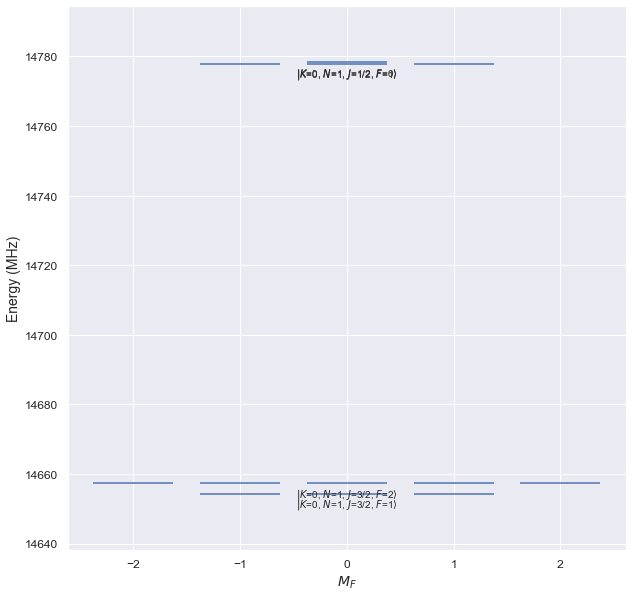

In [11]:
X010.display_levels(0,1e-6,'F')

In [122]:
allgvals = np.copy(X010.evals0)
zero = allgvals[0]
allgvals -= zero
idx = X010.select_q({'N':1,'J':1/2})
E_SR = min(X010.evals0[idx]-zero)
# for i, gv in enumerate(allgvals):
#     if i in idx:
#         minE = min(X010.evals0[idx]-zero)
#         allgvals[i] -= minE

In [348]:
gvals = allgvals 

evals = A000.evals0[e_all]
evals-=evals[0]

dark = np.array([0])

size = gvals.size+evals.size+dark.size

In [126]:
allgvals

array([  0.     ,   0.     ,   0.     ,   3.03018,   3.03018,   3.03018,
         3.03018,   3.03018, 123.54507, 123.54508, 123.54508, 124.0029 ])

In [349]:
H0 = np.zeros((size,size))
diag = np.diag_indices(size)
H0[diag] = np.round(np.concatenate((evals[::-1],gvals[::-1],dark)),5)

In [350]:
e_labels = y_labels[::-1]
g_labels = x_labels[::-1]
all_labels = [*e_labels,*g_labels,'dark']

In [351]:
all_labels

['$|+,J=\\frac{3}{2},F=1,M=1\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=1,M=0\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=1,M=-1\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=2\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=1\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=0\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=-1\\rangle\\,$',
 '$|+,J=\\frac{3}{2},F=2,M=-2\\rangle\\,$',
 '$|-,N=1,J=\\frac{1}{2},F=0,M=0\\rangle\\,$',
 '$|-,N=1,J=\\frac{1}{2},F=1,M=-1\\rangle\\,$',
 '$|-,N=1,J=\\frac{1}{2},F=1,M=0\\rangle\\,$',
 '$|-,N=1,J=\\frac{1}{2},F=1,M=1\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=2,M=2\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=2,M=1\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=2,M=0\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=2,M=-1\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=2,M=-2\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=1,M=1\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=1,M=0\\rangle\\,$',
 '$|-,N=1,J=\\frac{3}{2},F=1,M=-1\\rangle\\,$',
 'dark']

In [499]:
TDM_Z = np.round(TDM0[slice(*es),slice(*gs)][::-1,::-1],4)
TDM_X = np.round(TDMx[slice(*es),slice(*gs)][::-1,::-1],4)
TDM_BR = np.round(TDM_total[slice(*es),slice(*gs)][::-1,::-1],4)

In [505]:
Hoff_Z = np.zeros((size,size))
Hoff_X = np.zeros((size,size))
BR = np.zeros((size,size))
for i in range(evals.size):
    for j in range(gvals.size,):
        _tdmz = TDM_Z[i,j]
        _tdmx = TDM_X[i,j]
        _tdmbr = TDM_BR[i,j]
        Hoff_Z[i,evals.size+j] = _tdmz
        Hoff_X[i,evals.size+j] = _tdmx
        BR[i,evals.size+j] = _tdmbr
BR*=np.sqrt(0.8944)
print((BR**2).sum(axis=1))
for i in range(evals.size):
    BR[i,-1]+= np.sqrt(1-(BR[i,:]**2).sum())
# BR*=np.sqrt(0.8944)
# for i in range(evals.size):
#     BR[i,-1] = np.sqrt(0.8944*0.3) + np.sqrt(1-0.8944)

[0.62605 0.62607 0.62609 0.62309 0.62926 0.62612 0.62841 0.62352 0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.     ]


In [506]:
(BR**2).sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [507]:
def exp_osc(t,args):
    w = args['w']
    return np.exp(1j*w*t)

def exp_conj(t,args):
    w = args['w']
    return np.exp(-1j*w*t)

def linear_ramp(t,args):
    m = args['slope']
    b = args['start']
    stop = args['stop']
    y = m*t+b
    if y>stop:
        return 0
    else:
        return y
    
def on_off(t,args):
    on = args['on']
    off = args['off']
    if t>on and t<off:
        return 1
    else:
        return 0

def exp_onoff(t,args):
    w = args['w']
    on = args['on']
    off = args['off']
    exp = np.exp(1j*w*t)
    if t>on and t<off:
        return 1*exp
    else:
        return 0

def expconj_onoff(t,args):
    w = args['w']
    on = args['on']
    off = args['off']
    exp = np.exp(-1j*w*t)
    if t>on and t<off:
        return 1*exp
    else:
        return 0

In [487]:
Isat = 5 #mW/cm^2
e_lifetime = 0.02
s_X = 1
s_Z = 1
dipole = 5.24 #Debye
dipole*= 0.503412 #convert Debye to MHz/(V/cm)
E_X = np.sqrt(s_X*Isat*0.753460627) #convert mW/cm^2 to (V/cm)^2 using 2/(c*eps_0)
E_Z = np.sqrt(s_Z*Isat*0.753460627)
Rabi_X = dipole*E_X
Rabi_Z = dipole*E_Z

In [488]:
two_photon = 0*2*np.pi
one_photon = 0*2*np.pi
Hd = np.zeros((size,size))
for i in range(evals.size):
    Hd[i,i]-= one_photon

In [489]:
qb = q_basis(size)
qd = q_dict(qb,all_labels)
qops = q_ops(qb)

In [490]:
time = np.linspace(0.0,3,10000)

In [491]:
H=[Qobj(H0+Hd)*2*np.pi,[Rabi_Z*2*np.pi*Qobj(Hoff_Z + Hoff_Z.T),on_off],[Rabi_X*2*np.pi*Qobj(Hoff_X),exp_onoff],[Rabi_X*2*np.pi*Qobj(Hoff_X.T),expconj_onoff]]
decohere_rate = 1 * 2*np.pi
J32_states = [qops[i][i] for i,label in enumerate(all_labels) if 'N=1,J=\\frac{3}{2}' in label]
J12_states = [qops[i][i] for i,label in enumerate(all_labels) if 'N=1,J=\\frac{1}{2}' in label]
e_states = [qops[i][i] for i,label in enumerate(all_labels) if '+,J=\\frac{3}{2}' in label]
dark_state = [qops[-1][-1]]
rho0 = sum(J32_states)/(len(J32_states))
decohere = [np.sqrt(decohere_rate)*qops[i][i] for i in range(len(qops))]
decay = np.sqrt(1/e_lifetime)*np.sqrt(0.9)*(Qobj(BR.T))
collapse=[*decohere,decay]
result = mesolve(H,rho0,time,collapse,[sum(e_states),sum(J12_states),sum(J32_states),*dark_state],args={'on':0,'off':3,'w':two_photon+E_SR*2*np.pi})

In [492]:
def prep_sim(decohere_rate=0.4*2*np.pi, decay_rate =1/e_lifetime*0.8944,):
    
    e_labels = y_labels[::-1]
g_labels = x_labels[::-1]
all_labels = [*e_labels,*g_labels,'dark']
    
    
    TDM_Z = np.round(TDM0[slice(*es),slice(*gs)][::-1,::-1],4)
TDM_X = np.round(TDMx[slice(*es),slice(*gs)][::-1,::-1],4)
TDM_BR = np.round(TDM_total[slice(*es),slice(*gs)][::-1,::-1],4)
    
    Hoff_Z = np.zeros((size,size))
Hoff_X = np.zeros((size,size))
BR = np.zeros((size,size))
for i in range(evals.size):
    for j in range(gvals.size,):
        _tdmz = TDM_Z[i,j]
        _tdmx = TDM_X[i,j]
        _tdmbr = TDM_BR[i,j]
        Hoff_Z[i,evals.size+j] = _tdmz
        Hoff_X[i,evals.size+j] = _tdmx
        BR[i,evals.size+j] = _tdmbr
BR*=np.sqrt(0.8944)
print((BR**2).sum(axis=1))
for i in range(evals.size):
    BR[i,-1]+= np.sqrt(1-(BR[i,:]**2).sum())
    
    Isat = 5 #mW/cm^2
e_lifetime = 0.02
s_X = 1
s_Z = 1
dipole = 5.24 #Debye
dipole*= 0.503412 #convert Debye to MHz/(V/cm)
E_X = np.sqrt(s_X*Isat*0.753460627) #convert mW/cm^2 to (V/cm)^2 using 2/(c*eps_0)
E_Z = np.sqrt(s_Z*Isat*0.753460627)
Rabi_X = dipole*E_X
Rabi_Z = dipole*E_Z
    qb = q_basis(size)
qd = q_dict(qb,all_labels)
qops = q_ops(qb)
    decohere_rate = 0.4 * 2*np.pi
    J32_states = [qops[i][i] for i,label in enumerate(all_labels) if 'N=1,J=\\frac{3}{2}' in label]
    J12_states = [qops[i][i] for i,label in enumerate(all_labels) if 'N=1,J=\\frac{1}{2}' in label]
    e_states = [qops[i][i] for i,label in enumerate(all_labels) if '+,J=\\frac{3}{2}' in label]
    dark_state = [qops[-1][-1]]
    rho0 = sum(J32_states)/(len(J32_states))
    decohere = [np.sqrt(decohere_rate)*qops[i][i] for i in range(len(qops))]
    decay_rate
    decay = np.sqrt(1/e_lifetime)*np.sqrt(0.9)*(Qobj(BR.T))
    collapse=[*decohere,decay]

def cpt_sim(twophoton):
    two_photon = twophoton*2*np.pi
#     one_photon = 0
#     Hd = np.zeros((size,size))
#     for i in range(evals.size):
#         Hd[i,i]-= one_photon
    H=[Qobj(H0+Hd)*2*np.pi,[Rabi_Z*2*np.pi*Qobj(Hoff_Z + Hoff_Z.T),on_off],[Rabi_X*2*np.pi*Qobj(Hoff_X),exp_onoff],[Rabi_X*2*np.pi*Qobj(Hoff_X.T),expconj_onoff]]
    decohere_rate = 0.4 * 2*np.pi
    J32_states = [qops[i][i] for i,label in enumerate(all_labels) if 'N=1,J=\\frac{3}{2}' in label]
    J12_states = [qops[i][i] for i,label in enumerate(all_labels) if 'N=1,J=\\frac{1}{2}' in label]
    e_states = [qops[i][i] for i,label in enumerate(all_labels) if '+,J=\\frac{3}{2}' in label]
    dark_state = [qops[-1][-1]]
    rho0 = sum(J32_states)/(len(J32_states))
    decohere = [np.sqrt(decohere_rate)*qops[i][i] for i in range(len(qops))]
    decay = np.sqrt(1/e_lifetime)*np.sqrt(0.9)*(Qobj(BR.T))
    collapse=[*decohere,decay]
    result = mesolve(H,rho0,time,collapse,[sum(e_states),sum(J12_states),sum(J32_states),*dark_state],args={'on':0,'off':3,'w':two_photon+E_SR*2*np.pi})
    return result.expect[1]

In [493]:
twophoton_array = np.arange(-10,10,0.1)
extraleft = np.arange(-35,-10,5)
extraright = np.arange(15,40,5)
twophoton_array = np.concatenate((extraleft,twophoton_array,extraright))

In [494]:
res_array = []
for two in twophoton_array:
    res_array.append(cpt_sim(two))

In [495]:
res_array=np.array(res_array)
res_array.shape

(210, 10000)

In [496]:
plt.figure(figsize=(12,8))
plt.title('J=1/2 population remaining',fontsize=20)
plt.xlabel('Two Photon Detuning Relative to F=1, J=1/2', fontsize=16)
plt.ylabel('Population',fontsize=16)
plt.plot(twophoton_array,res_array[:,-1])

In [445]:
plt.figure()
for trace in res:
    plt.plot(time,trace)

for trace,k in zip(res,['Excited','J=1/2','J=3/2','other']):
    plt.figure()
    plt.title(k)
    plt.plot(time,trace)

In [101]:
# generate n level basis
def q_basis(n):
    q_basis = []
    for i in range(n):
        q_basis.append(basis(n,i))
    return q_basis

def q_dict(q_basis, q_str):
    q_dict = {qs: qb for qs,qb in zip(q_str, q_basis)}
    return q_dict

def q_ops(q_basis):
    n = len(q_basis)
    q_ops = np.zeros((n,n)).tolist()
    for i in range(n):
        for j in range(n):
            q_ops[i][j] = q_basis[i]*q_basis[j].dag()
    return q_ops

In [103]:
qb = q_basis(size)
qd = q_dict(qb,all_labels)
qops = q_ops(qb)

In [93]:
sy.Matrix(np.round(TDM0[slice(*es),slice(*gs)],4))

Matrix([
[0.0009,      0, 0.0009,  0.5657, -0.0016,       0,  0.0015,       0,  0.0016,      0, -0.0016,       0],
[ 0.169,      0, 0.0003, -0.0031, -0.2828,       0,  0.0004,       0,  0.0004,      0, -0.2854,       0],
[     0, 0.1952,      0,       0,       0,       0,       0,       0,       0, 0.3295,       0,       0],
[0.0003,      0, -0.169,  0.0031, -0.0004,       0, -0.2828, -0.0034, -0.2854,      0, -0.0004,       0],
[     0,      0,  0.001,       0,       0,       0,  0.0017, -0.5657,  0.0017,      0,       0,       0],
[ 0.468,      0,      0,       0, -0.1633,       0,       0,       0,       0,      0,   0.176,       0],
[     0,      0,      0,       0,       0, -0.1886,       0,       0,       0,      0,       0, -0.3333],
[     0,      0,  0.468,       0,       0,       0,  0.1633,       0,  -0.176,      0,       0,       0]])

In [92]:
sy.Matrix(np.round(TDM0[slice(*es),slice(*gs)][::-1,::-1],4))

Matrix([
[      0,       0,      0,  -0.176,       0,  0.1633,       0,       0,       0,  0.468,      0,      0],
[-0.3333,       0,      0,       0,       0,       0, -0.1886,       0,       0,      0,      0,      0],
[      0,   0.176,      0,       0,       0,       0,       0, -0.1633,       0,      0,      0,  0.468],
[      0,       0,      0,  0.0017, -0.5657,  0.0017,       0,       0,       0,  0.001,      0,      0],
[      0, -0.0004,      0, -0.2854, -0.0034, -0.2828,       0, -0.0004,  0.0031, -0.169,      0, 0.0003],
[      0,       0, 0.3295,       0,       0,       0,       0,       0,       0,      0, 0.1952,      0],
[      0, -0.2854,      0,  0.0004,       0,  0.0004,       0, -0.2828, -0.0031, 0.0003,      0,  0.169],
[      0, -0.0016,      0,  0.0016,       0,  0.0015,       0, -0.0016,  0.5657, 0.0009,      0, 0.0009]])

In [15]:
sy.Matrix(np.round(TDM0[slice(*es),slice(*gs)],4))

Matrix([
[0.0009,      0, 0.0009,  0.5657, -0.0016,       0,  0.0015,       0,  0.0016,      0, -0.0016,       0],
[ 0.169,      0, 0.0003, -0.0031, -0.2828,       0,  0.0004,       0,  0.0004,      0, -0.2854,       0],
[     0, 0.1952,      0,       0,       0,       0,       0,       0,       0, 0.3295,       0,       0],
[0.0003,      0, -0.169,  0.0031, -0.0004,       0, -0.2828, -0.0034, -0.2854,      0, -0.0004,       0],
[     0,      0,  0.001,       0,       0,       0,  0.0017, -0.5657,  0.0017,      0,       0,       0],
[ 0.468,      0,      0,       0, -0.1633,       0,       0,       0,       0,      0,   0.176,       0],
[     0,      0,      0,       0,       0, -0.1886,       0,       0,       0,      0,       0, -0.3333],
[     0,      0,  0.468,       0,       0,       0,  0.1633,       0,  -0.176,      0,       0,       0]])

In [5]:
import matplotlib as mpl
font_paths = mpl.font_manager.findSystemFonts()
fonts = [f for f in font_paths if 'OpenSans' in f]
for f in fonts:
    print(f)
    mpl.font_manager.fontManager.addfont(str(f))

C:\WINDOWS\Fonts\OpenSans-VariableFont_wdth,wght.ttf
C:\Windows\Fonts\OpenSans-VariableFont_wdth,wght.ttf
C:\WINDOWS\Fonts\OpenSans-Italic-VariableFont_wdth,wght.ttf
C:\Windows\Fonts\OpenSans-Italic-VariableFont_wdth,wght.ttf


In [6]:
sns.set_style('white')

In [7]:
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'axes.grid': False,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': <CapStyle.round: 'round'>,
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

In [8]:
sns.set_style({'font.family':['Open Sans'],'ytick.left':False,'xtick.bottom':False, 'axes.spines.left':False,'axes.spines.left':False,'axes.spines.right':False,'axes.spines.top':False,'axes.spines.bottom':False})

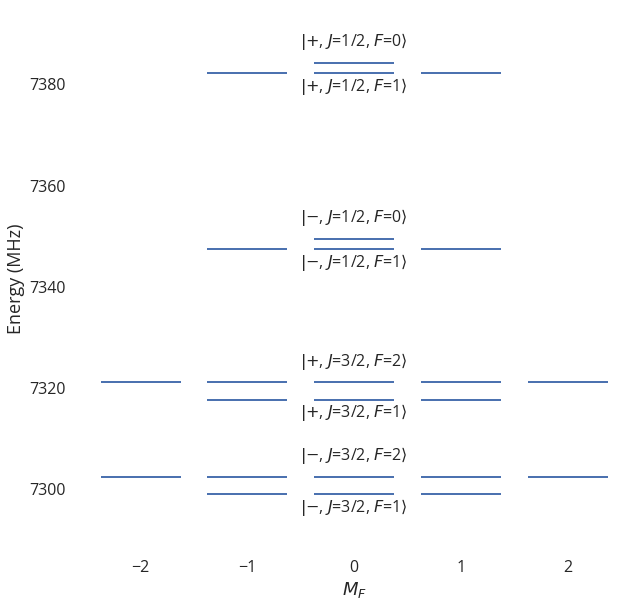

In [19]:
X010.display_levels(0,1e-6,'F',parity=True,label=True,pretty=True,thickness=2,alt_label=True,label_q=['J','F'],label_size=18, ket_size=16,label_off=0.04);
# sns.despine()
plt.savefig('YbOH_X010_N1.svg')

In [21]:
import matrix_elements_sym as me
from functools import partial
from matrix_elements_sym import decouple_b_even

def H_even_X(q_numbers,params,matrix_elements,symbolic=True,E=0,B=0,M_values='all',precision=5):
    q_str = list(q_numbers)     # Get keys for quantum number dict
    if symbolic:
        Ez,Bz = sy.symbols('E_z B_z')
        size = len(q_numbers[q_str[0]])
        # Need to construct empty matrices to fill with matrix elements
        # Sympy does not like numpy arrays, so convert to list
        H0 = np.zeros((size,size)).tolist()
        V_B = np.zeros((size,size)).tolist()
        V_E = np.zeros((size,size)).tolist()
        if params.get('D') is not None:
            N0 = np.zeros((size,size)).tolist()
        if params.get('q_lD_D') is not None:
            lD0 = np.zeros((size,size)).tolist()
        #Iz = np.zeros((size,size)).tolist()
        #Sz = np.zeros((size,size)).tolist()
        for i in range(size):
            for j in range(size):
                # State out is LHS of bra ket, state in is RHS
                state_out = {q+'0':q_numbers[q][i] for q in q_str}
                state_in = {q+'1':q_numbers[q][j] for q in q_str}
                q_args = {**state_out,**state_in}
                elements = {term: sy.N(element(**q_args)) for term, element in matrix_elements.items()}
                # The Hamiltonian
                H0[i][j] = params['Be']*elements['N^2'] + params['Gamma_SR']*elements['N.S'] + \
                    params['bF']*elements['I.S'] + params['c']/3*np.sqrt(6)*elements['T2_0(I,S)']
                if params.get('q_lD') is not None:
                    H0[i][j] += params['p_lD']*elements['l doubling p'] - params['q_lD']*elements['l doubling q'] -params['Gamma_SR']*elements['NzSz']+params['Gamma_Prime']*elements['NzSz'] #old: params['q_lD']/2*elements['l-doubling']
                    # H0[i][j] += -params['q_lD']/2*elements['l-doubling'] - params['Gamma_SR']*elements['NzSz']+params['Gamma_Prime']*elements['NzSz']
                if M_values!='none':
                    V_B[i][j]+=params['g_S']*params['mu_B']*elements['ZeemanZ']
                    V_E[i][j]+=-params['muE']*elements['StarkZ']
                if params.get('D') is not None:
                    N0[i][j] += elements['N^2']
                if params.get('q_lD_D') is not None:
                    lD0[i][j] += elements['l doubling q']
                # H[i][j] = round(H[i][j],precision)
                #Iz[i][j] = params['c']*elements['Iz']
                #Sz[i][j] = elements['Sz']
        # Need to add centrifugal terms
        if params.get('D') is not None:
            H0 = matadd(H0,scalarmult(-params['D'],matmult(N0,N0)))
        if params.get('q_lD_D') is not None:
            H0 = matadd(H0,scalarmult(-params['q_lD_D']/2,(matadd(matmult(lD0,N0),matmult(N0,lD0)))))
        #H=matadd(H,matmult(Iz,Sz))
        # Create symbolic object
        H_symbolic = sy.Matrix(H0)+Ez*sy.Matrix(V_E)+Bz*sy.Matrix(V_B)
#         H0_num = np.array(H0).astype(np.float64)
#         V_E_num = np.array(V_E).astype(np.float64)
#         V_B_num = np.array(V_B).astype(np.float64)
        # Use symbolic object to create function that given E and B values, returns a numpy array
#         H_func = lambda E,B: H0_num + V_E_num*E + V_B_num*B
        # H_func = sy.lambdify((Ez,Bz), H_symbolic, modules='numpy')
        return H_symbolic
                        
def matmult(a,b):
    zip_b = list(zip(*b))
    return [[sum(ele_a*ele_b for ele_a, ele_b in zip(row_a, col_b))
             for col_b in zip_b] for row_a in a]

def scalarmult(s,mat):
    return [[s*ele for ele in inner] for inner in mat]

def matadd(a,b):
    return [[ele_a+ele_b for ele_a,ele_b in zip(row_a,row_b)] for row_a,row_b in zip(a,b)]

def decouple_b(input_qnumbers,output_qnumbers,S=1/2,I=0):
    input_keys = list(input_qnumbers)
    output_keys = list(output_qnumbers)
    input_size = len(input_qnumbers[input_keys[0]])
    output_size = len(output_qnumbers[output_keys[0]])
    basis_matrix = np.zeros((output_size,input_size)).tolist()
    for i in range(output_size):
        for j in range(input_size):
            decoupled_qnumbers = {q:output_qnumbers[q][i] for q in output_keys}
            b_qnumbers = {q:input_qnumbers[q][j] for q in input_keys}
            basis_matrix[i][j] = sy.nsimplify(decouple_b_even(decoupled_qnumbers,b_qnumbers,S=S,I=I))
    return basis_matrix
   
    

bBJ_even_X_matrix_elements={
        # Fine Structure
        'N^2': me.Rot_bBJ,                 # N^2 Rotation
        'N.S': me.SR_bBJ,                  # N.S Spin Rotation
        'l-doubling': me.lD_bBJ,           # Effective l doubling
        'l doubling p':me.p_lD_bBJ,
        'l doubling q':me.q_lD_bBJ,
        'NzSz': me.NzSz_bBJ,               # NzSz for bending mode

        # Hydrogen Hyperfine
        'I.S': me.IS_bBJ,                  # I.S Fermi Contact Interaction
        'T2_0(I,S)': me.T2IS_bBJ,          # I S dipolar interaction
        'Iz': me.Iz_bBJ,                   # I.n projection of I on internuclear axis n
        'Sz': me.Sz_bBJ,                   # S.n projection of S on internuclear axis n
        }

ext_fields = {
# External Fields
'ZeemanZ': me.ZeemanZ_bBJ,         # Zeeman interaction with lab z magnetic field
'StarkZ': me.StarkZ_bBJ            # Stark interaction with lab z electric field
}
bBJ_even_X_matrix_elements.update(ext_fields)
for term,element in bBJ_even_X_matrix_elements.items():       #iterate through, substitute hydrogen proton value
            bBJ_even_X_matrix_elements[term] = partial(element,I=1/2)

        

B,D,gamma,gammap, bF,c,b,q_lD,p_lD,muE,muB,g_S,g_L = sy.symbols('B_{rot} D gamma gamma^\' b_F c b q_{lD} p_{lD} D_z mu_B g_S g_L')
params_174X010 = {
'Be': 0*B,
'Gamma_SR': gamma,
'Gamma_Prime': gammap,
'bF': bF,
'c': c,
'b': 0*(4.80-2.46/3),
'q_lD': q_lD, #Should be minus if neg parity lower and parity is (-1)^(J-l-S), but for modeling I treat this as positive for now....
'p_lD': p_lD,
'muE': 0*muE,
'Origin': 0,
'g_l': 0.0,
'g_S':2.07,
'mu_B':0*muB
}


# params_40X010 = {
# 'Be': B,#10023.0841,
# 'D': 0,#1.154*10**-2,
# 'Gamma_SR':gamma,# 34.7593,
# 'bF': bF,#2.602,
# 'c': c,#2.053,
# 'b': (2.602-2.053/3),
# # 'muE': 1.465*0.503412 #Debye in MHz/(V/cm)
# }

def build_operator(q_numbers,parameter,operator_element,M_values='all',precision=5):
    q_str = list(q_numbers)     # Get keys for quantum number dict
    size = len(q_numbers[q_str[0]])
    # Need to construct empty matrices to fill with matrix elements
    # Sympy does not like numpy arrays, so convert to list
    H0 = np.zeros((size,size)).tolist()
    #Iz = np.zeros((size,size)).tolist()
    #Sz = np.zeros((size,size)).tolist()
    for i in range(size):
        for j in range(size):
            # State out is LHS of bra ket, state in is RHS
            state_out = {q+'0':q_numbers[q][i] for q in q_str}
            state_in = {q+'1':q_numbers[q][j] for q in q_str}
            q_args = {**state_out,**state_in}
            operator = sy.nsimplify(operator_element(**q_args))
            H0[i][j]+= parameter*operator
    H_symbolic = sy.Matrix(H0)
    return H_symbolic

In [22]:
X010 = MoleculeLevels.initialize_state('YbOH','174','X010',[1],M_values = 'custom',M_range=[0],I=[0,1/2],S=1/2,round=8,P_values=[1/2,3/2])

In [23]:
X010.q_numbers

{'K': [-1, 1, -1, 1, -1, 1, -1, 1],
 'N': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'J': [0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 1.5, 1.5],
 'F': [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0],
 'M': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

In [24]:
H_sym010 = H_even_X(X010.q_numbers,params_174X010,bBJ_even_X_matrix_elements,symbolic=True,E=0,B=0,M_values='custom',precision=8)

In [25]:
H_sym010

Matrix([
[0.25*b_F + 0.166666666666667*c - 0.5*gamma - 0.5*gamma^',                                 -0.5*p_{lD} - 1.0*q_{lD},                                                                        0,                                                                        0,                                                                         0,                                                                         0,                                                           0,                                                           0],
[                                -0.5*p_{lD} - 1.0*q_{lD}, 0.25*b_F + 0.166666666666667*c - 0.5*gamma - 0.5*gamma^',                                                                        0,                                                                        0,                                                                         0,                                                                         0,                                       

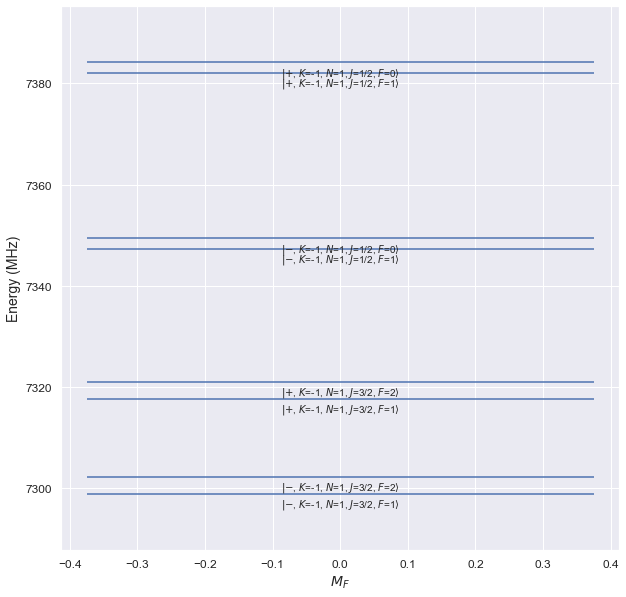

In [26]:
X010.display_levels(0,0,'F',parity=True)

In [27]:
X010.eigensystem(0,0)
x = sy.Matrix(X010.evecs0[2]).T*H_sym010*sy.Matrix(X010.evecs0[2])
y = sy.Matrix(X010.evecs0[3]).T*H_sym010*sy.Matrix(X010.evecs0[3])
d1 = sy.N(y-x)[0].evalf(4)
d1

0.6979*b_F + 0.04184*c + 0.0008465*gamma + 0.0008465*gamma^' + 0.0008465*p_{lD} + 1.472e-8*q_{lD}

In [28]:
X010.eigensystem(0,0)
x = sy.Matrix(X010.evecs0[6]).T*H_sym010*sy.Matrix(X010.evecs0[6])
y = sy.Matrix(X010.evecs0[7]).T*H_sym010*sy.Matrix(X010.evecs0[7])
d2 = sy.N(y-x)[0].evalf(4)
d2

0.3021*b_F + 0.2248*c - 0.0008465*gamma - 0.0008465*gamma^' - 0.0008465*p_{lD} + 1.472e-8*q_{lD}

In [29]:
d2-d1

-0.3959*b_F + 0.183*c - 0.001693*gamma - 0.001693*gamma^' - 0.001693*p_{lD}

In [76]:
X010.eigensystem(0,0)
x = sy.Matrix(X010.evecs0[2]).T*H_sym010*sy.Matrix(X010.evecs0[2])
y = sy.Matrix(X010.evecs0[6]).T*H_sym010*sy.Matrix(X010.evecs0[6])
d3 = sy.N(y-x)[0].evalf(4)
d3

0.3959*b_F - 0.03299*c - 0.7483*gamma - 0.7483*gamma^' - 0.7483*p_{lD} - 2.22e-16*q_{lD}

In [73]:
X010.eigensystem(0,0)
x = sy.Matrix(X010.evecs0[2]).T*H_sym010*sy.Matrix(X010.evecs0[2])
y = sy.Matrix(X010.evecs0[7]).T*H_sym010*sy.Matrix(X010.evecs0[7])
d4 = sy.N(y-x)[0].evalf(4)
d4

0.6979*b_F + 0.1918*c - 0.7492*gamma - 0.7492*gamma^' - 0.7492*p_{lD} + 1.472e-8*q_{lD}

In [68]:
d4-d3

0.3021*b_F + 0.2248*c - 0.0008469*gamma - 0.0008469*gamma^' - 0.0008469*p_{lD} + 1.472e-8*q_{lD}

In [65]:
X010.eigensystem(0,0)
x = sy.Matrix(X010.evecs0[0]).T*H_sym010*sy.Matrix(X010.evecs0[0])
y = sy.Matrix(X010.evecs0[1]).T*H_sym010*sy.Matrix(X010.evecs0[1])
sy.N(y-x)[0]

0.499999998321968*p_{lD} - 1.99999999328787*q_{lD}

In [69]:
X010.eigensystem(0,0)
x = sy.Matrix(X010.evecs0[1]).T*H_sym010*sy.Matrix(X010.evecs0[1])
y = sy.Matrix(X010.evecs0[2]).T*H_sym010*sy.Matrix(X010.evecs0[2])
sy.N(y-x)[0]

-0.749999997482953*gamma - 0.749999997482953*gamma^' + 0.249999999160984*p_{lD} + 1.99999999328787*q_{lD}

In [70]:
X010.eigensystem(0,0)
x = sy.Matrix(X010.evecs0[2]).T*H_sym010*sy.Matrix(X010.evecs0[2])
y = sy.Matrix(X010.evecs0[3]).T*H_sym010*sy.Matrix(X010.evecs0[3])
sy.N(y-x)[0]

-0.999999996643936*p_{lD} - 1.99999999328787*q_{lD}

In [82]:
12.03*2+10.73

34.79

In [89]:
2*-12.03+1/4*-10.73 - 0.75*-88.66 - 0.75*15.61

28.045000000000005

In [83]:
12.03*2-10.73/2

18.695

In [58]:
X010.evals0

array([7298.86866, 7302.275  , 7317.58785, 7320.97   , 7347.33434,
       7382.10015])

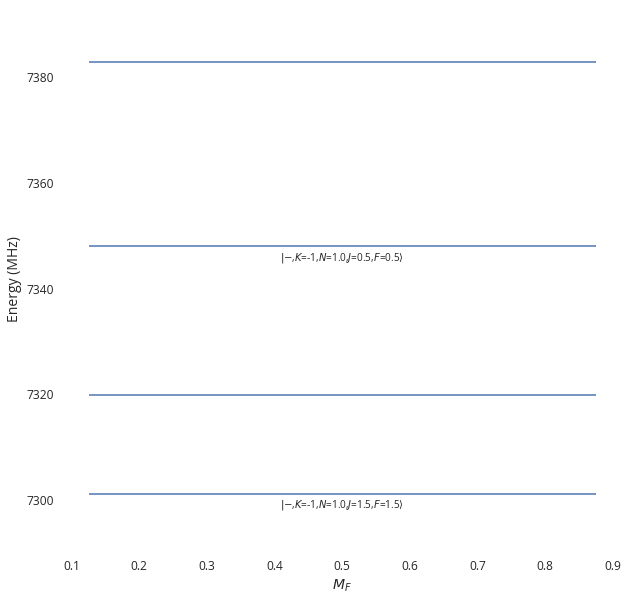

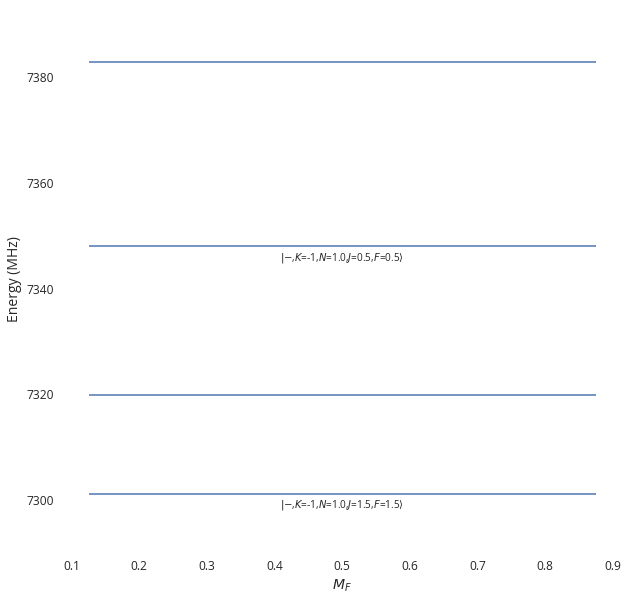

In [68]:
X010.display_levels(0,0,'F',parity=True)

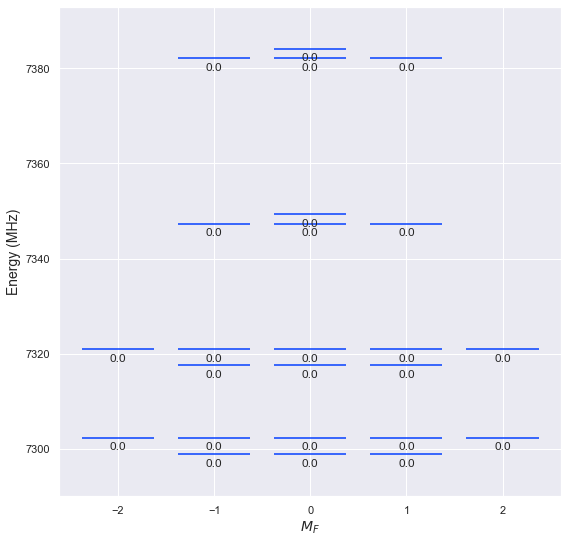

In [36]:
X010.display_D_eff(0,1e-3,round=3)

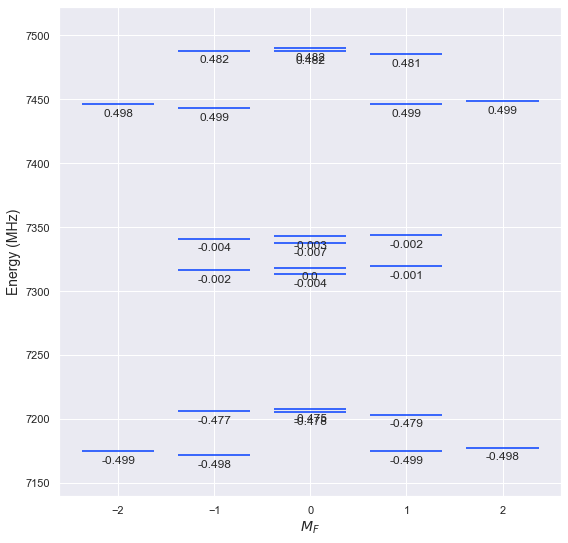

In [35]:
X010.display_(250,1,round=3)

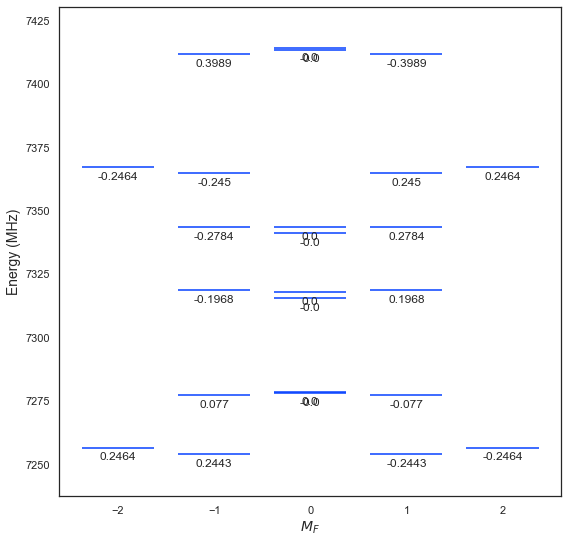

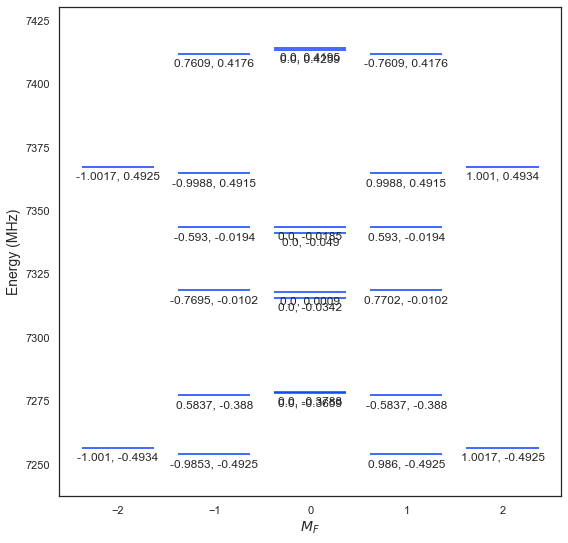

In [45]:
E0=100.8
X010.display_PTV(E0,1e-5,'EDM',round=4)
X010.display_g_D_eff(E0,1e-5,round=4)

In [27]:
X010.eigensystem(0,1e-3)
zero1_idx = X010.select_q({'N':1,'J':[0.5],'F':[1],'M':[-1,1]},parity='-')
zero2_idx = X010.select_q({'N':1,'J':[1.5],'F':[2],'M':[-1,1]},parity='-')

In [30]:
Bz = np.linspace(1e-4,10,1001)
Ez = np.linspace(0,300,10001)

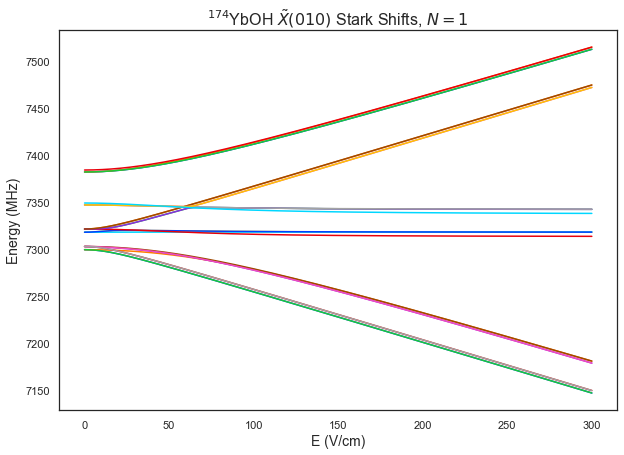

In [46]:
X010.StarkMap(Ez,1e-6,plot=True)
g_v_E=X010.g_eff_Map(step=1e-5)

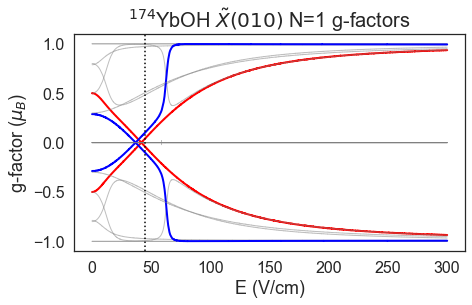

In [38]:
sns.set_style('white')
plt.figure(figsize=(7,4))
alpha=0.2
for i in range(len(X010.g_eff_E.T)):#range(len(X010_174.g_eff_E.T)):
    if i in zero1_idx or i in zero2_idx:
        alpha = 1
        if i in zero1_idx:
            color = 'blue'
        else:
            color='red'
        plt.plot(Ez,X010.g_eff_E.T[i],alpha=alpha,linewidth=2,color=color)
    else:
        alpha = 0.5
        plt.plot(Ez,X010.g_eff_E.T[i],alpha=alpha,linewidth=1,color='gray')
plt.axvline(44.4,color='black',linestyle='dotted')
# plt.axvline(62,color='black',linestyle='dotted')
plt.xlabel('E (V/cm)',fontsize=18)
plt.ylabel(r'g-factor ($\mu_B$)',fontsize=18)
plt.title(X010.state_str + ' N=1 g-factors',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([-1,-0.5,0,0.5,1],fontsize=16);
# plt.tight_layout()
# plt.savefig('YbOH_N1_gfactor_vsE.svg',bbox_inches='tight')

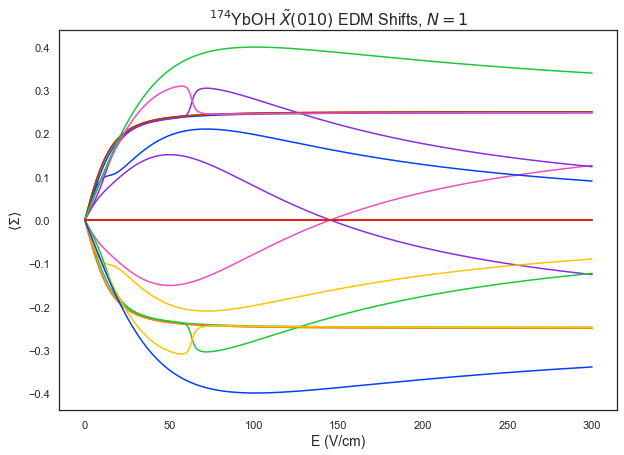

In [39]:
X010.PTV_Map('EDM',plot=True)

In [44]:
for ptv in X010.PTV_E.T:
    print(max(ptv),Ez[np.argmax(ptv)])

0.2474503 300.0
1.035e-05 300.0
0.0 0.0
0.24959149 300.0
0.15075349 50.129999999999995
3.3e-07 111.78
0.12575477 300.0
0.0 0.0
0.0 0.0
0.00014838 58.68
0.2098582 71.82
0.0 0.0
0.0 0.0
0.00113231 58.65
0.3040371 71.97
0.24959149 300.0
0.30887298 57.33
0.00012173 50.04
0.0 0.0
8.013e-05 50.01
0.0 0.0
0.0 0.0
0.39888257 100.8
8.13e-06 300.0


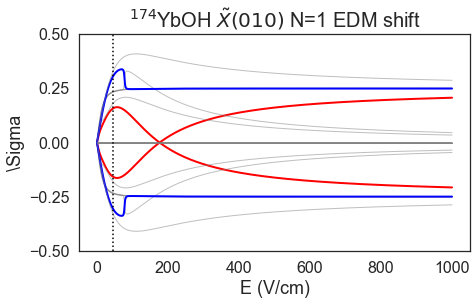

In [78]:
sns.set_style('white')
plt.figure(figsize=(7,4))
alpha=0.2
for i in range(len(X010.PTV_E.T)):#range(len(X010_174.g_eff_E.T)):
    if i in zero1_idx or i in zero2_idx:
        alpha = 1
        if i in zero1_idx:
            color = 'blue'
        else:
            color='red'
        plt.plot(Ez,X010.PTV_E.T[i],alpha=alpha,linewidth=2,color=color)
    else:
        alpha = 0.5
        plt.plot(Ez,X010.PTV_E.T[i],alpha=alpha,linewidth=1,color='gray')
plt.axvline(44.4,color='black',linestyle='dotted')
# plt.axvline(62,color='black',linestyle='dotted')
plt.xlabel('E (V/cm)',fontsize=18)
plt.ylabel(r'\Sigma',fontsize=18)
plt.title(X010.state_str + ' N=1 EDM shift',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks([-0.5,-0.25,0,0.25,0.5],fontsize=16);
# plt.tight_layout()
# plt.savefig('YbOH_N1_gfactor_vsE.svg',bbox_inches='tight')

In [5]:
B0 = 1e-1
E0 = 250
evals, evecs = X010.eigensystem(E0,B0,order=True,method='torch')

Text(0.5, 1.0, 'G=1 Zeeman Shifts')

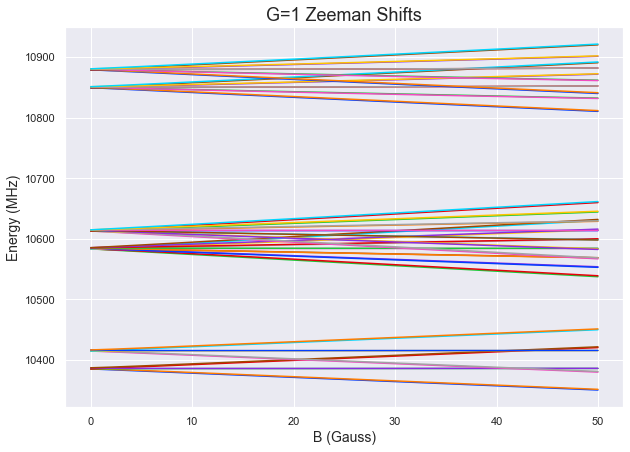

In [25]:
X010.ZeemanMap(Bz,0,plot=True,idx = X010.select_q({'G':2}))
plt.title('G=1 Zeeman Shifts',fontsize=18)

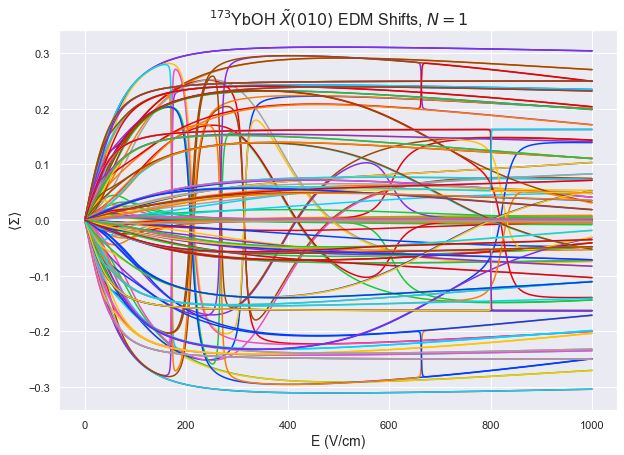

In [41]:
X010.PTV_Map('EDM',E_or_B='E',plot=True)

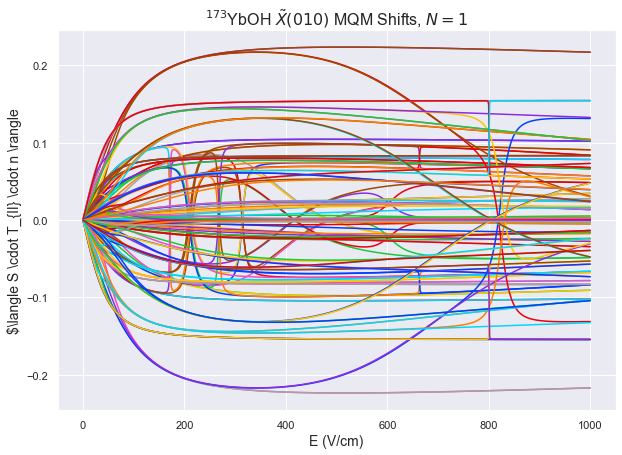

In [35]:
X010.PTV_Map('MQM',E_or_B='E',plot=True)

In [28]:
X010.g_eff_Map(step=1e-6);

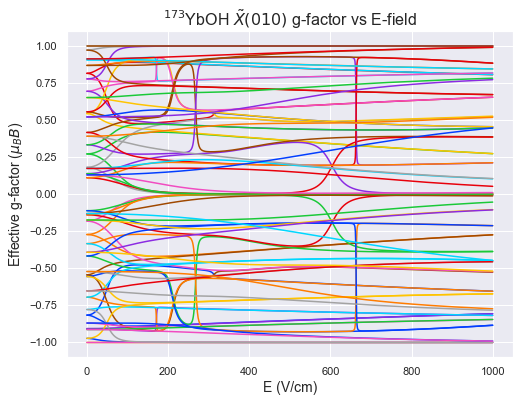

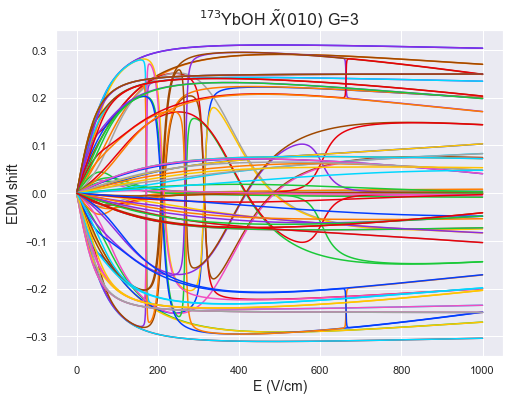

In [44]:
qd={'G':3}
plt.figure(figsize=(8,6))
for i in X010.select_q(qd):#range(len(X010_174.g_eff_E.T)):
#     if abs(X010.PTV_E.T[i]).mean()<0.05:
#         continue
    plt.plot(Ez,X010.g_eff_E.T[i])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel(r'Effective g-factor ($\mu_B B$)',fontsize=14)
plt.title(X010.state_str + ' g-factor vs E-field',fontsize=16);
plt.figure(figsize=(8,6))
for i in X010.select_q(qd):#range(len(X010_174.PTV_E.T)):
#     if abs(X010.PTV_E.T[i]).mean()<0.05:
#         continue
    plt.plot(Ez,X010.PTV_E.T[i])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('EDM shift',fontsize=14)
plt.title(X010.state_str+' G={}'.format(qd['G'][0]),fontsize=16);

Text(0.5, 1.0, '$^{173}$YbOH $\\tilde{X}(010)$ MQM Shifts, G=3, E=300 V/cm')

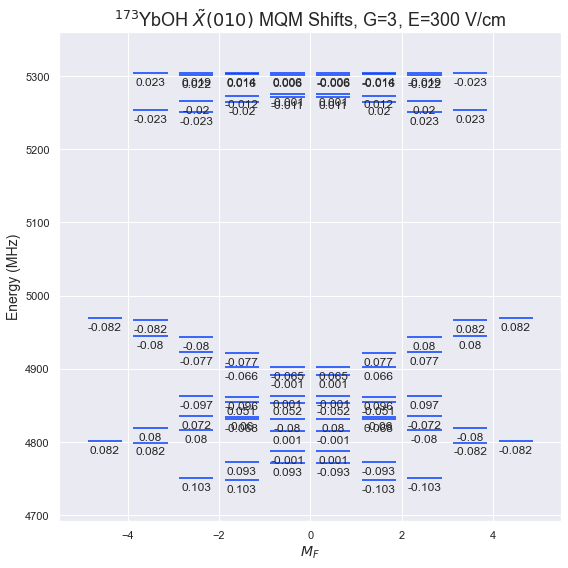

In [62]:
X010.display_PTV(300,1e-4,'MQM',idx=X010.select_q({'G':3}),round=3)
# plt.ylim(10300,10500)
plt.xlim(-5.5,5.5)
plt.title(X010.state_str + ' MQM Shifts, G=3, E=300 V/cm',fontsize=18)

(-2.5, 2.5)

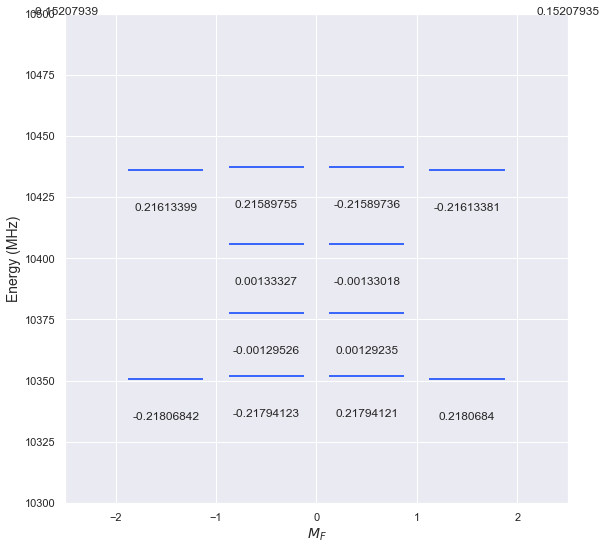

In [52]:
X010.display_PTV(300,1e-3,'MQM',idx=X010.select_q({'G':2}))
plt.ylim(10300,10500)
plt.xlim(-2.5,2.5)

Text(0.5, 1.0, 'CaOH X(010) N=2+,J=3/2 Zeeman Shifts')

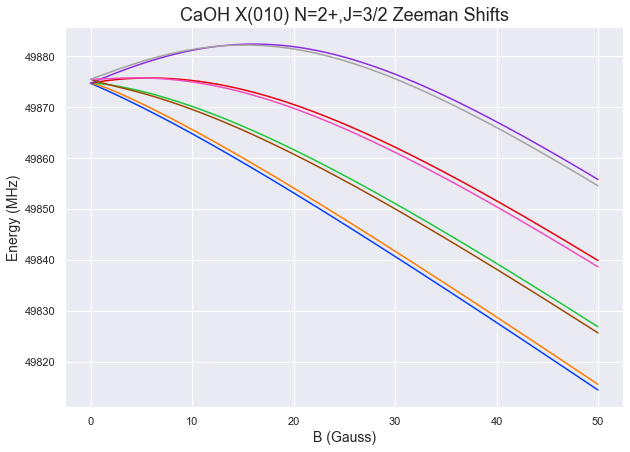

In [243]:
X010.ZeemanMap(Bz,0,plot=True,idx = X010.select_q({'N':2,'J':1.5},parity='+'))
plt.title('CaOH X(010) N=2+,J=3/2 Zeeman Shifts',fontsize=18)

In [22]:
X010 = MoleculeLevels.initialize_state('YbOH','174','X010',[1],M_values = 'custom',M_range=[1],I=[0,1/2],S=1/2,round=8,P_values=[1/2,3/2])

In [28]:
B0 = 1e-4
E0 = 0
evals, evecs = X010.eigensystem(E0,B0,order=True,method='torch')
M0_idx = X010.select_q({'N':1},parity='-')
print(M0_idx)
print('\n')
for i in M0_idx:
    display(Latex('$E = '+str(np.round(X010.evals0[i],4))+r'\:\mathrm{MHz}$'))
    print('Parity=',X010.parities[i])

#     print('Decoupled:')
#     display(Latex(X010.gen_state_str(i,basis='decoupled',thresh=0.05,label_q=['K','M_N','M_S','M_I','M_F'],round=4)))
    print('Case A:')
    display(Latex(X010.gen_state_str(i,basis='aBJ',thresh=0.05,label_q=['K','J','F','Sigma','P','M'],round=6)))
    print('Case B:')
    display(Latex(X010.gen_state_str(i,thresh=0.0005,round=4)))
    print('\n')

[0 1 4]




<IPython.core.display.Latex object>

Parity= -1.0
Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Parity= -1.0
Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Parity= -1.0
Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

In [282]:
E0=50
B0=1e-4
TDM0 = 1.465*Calculate_TDMs(0,N1,N2,E0,B0,[0])
# TDMp = 1.465*Calculate_TDMs(1,X010,X010,E0,B0)
# TDMm = 1.465*Calculate_TDMs(-1,X010,X010,E0,B0)
# TDMx = -1/np.sqrt(2)*(TDMp - TDMm)

Successfully converted eigenvectors from bBJ to aBJ
Successfully converted eigenvectors from bBJ to aBJ


In [283]:
def l2s(inputlist):
      """
      Convert a flatten list to a list of slices:
      test = [0,2,3,4,5,6,12,99,100,101,102,13,14,18,19,20,25]
      list_to_slices(test)
      -> [(0, 0), (2, 6), (12, 14), (18, 20), (25, 25), (99, 102)]
      """
      inputlist.sort()
      pointers = np.where(np.diff(inputlist) > 1)[0]
      pointers = zip(np.r_[0, pointers+1], np.r_[pointers, len(inputlist)-1])
      slices = [(inputlist[i], inputlist[j]+1) for i, j in pointers]
      return slices

In [286]:
N1_all = N1.select_q({'N':1,'F':0},parity='-')
N2_all = N2.select_q({'N':2,'M':0},parity='+')

In [289]:
N2s

(4, 5)

C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_20532/4255074159.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(mat, ax=ax,fraction=0.015, pad=0.05)


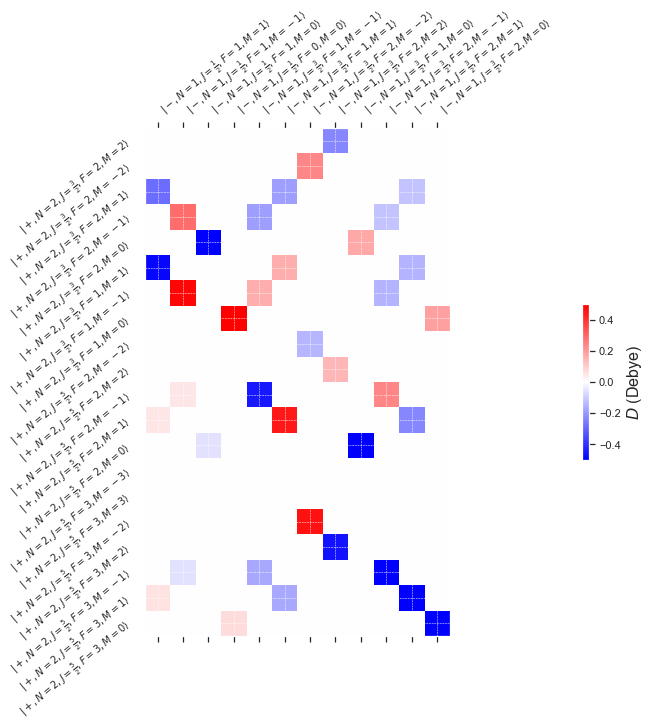

In [290]:
fig,ax = plt.subplots(figsize=(10,10),constrained_layout=True)
# ax.set_aspect('equal')
N1_all = N1.select_q({'N':1},parity='-')
N2_all = N2.select_q({'N':2},parity='+')
N1s = l2s(N1_all)[0]
N2s = l2s(N2_all)[0]
N1l = np.arange(*N1s)
N2l = np.arange(*N2s)
log=False
BR_plot = TDM0 #convert MHz/V/cm to Debye
if log:
    BR_plot=np.log10(BR_plot)
    vmin = -10
    vmax = 0
else:
    vmin=None
    vmax = None
#     log_BR = np.copy(BR0)
#     for i,val1 in enumerate(log_BR):
#         for j,val2 in enumerate(val1):
#             if val2 !=0:
#                 log_BR[i,j] = np.log10(val2)
#     BR_plot = log_BR
mat = ax.matshow(BR_plot[slice(*N2s),slice(*N1s)],cmap=plt.get_cmap('bwr'),vmax = 0.5, vmin = -0.5)
y = np.arange(0,len(N2l))
x = np.arange(0,len(N1l))
ax.set_yticks(y)
ax.set_xticks(x)
y_labels = [N2.gen_state_str(i,thresh=0.2,single=True,parity=True,show_coeff=False, label_q=['N','J','F','M']) for i in N2l]
x_labels = [N1.gen_state_str(i,thresh=0.2,single=True,parity=True,show_coeff=False, label_q=['N','J','F','M']) for i in N1l]
# x_labels = [X010.gen_state_str(i,thresh=0.3,single=True,parity=False,show_coeff=True, basis='decoupled',label_q=['K','M_N','M_S','M_F'],round=2) for i in N2]
# y_labels = [X010.gen_state_str(i,thresh=0.3,single=True,parity=False,show_coeff=True, basis='decoupled',label_q=['K','M_N','M_S','M_F'],round=2) for i in N1]
ax.set_yticklabels(y_labels, rotation='40', fontsize=12, ha='right')
ax.set_xticklabels(x_labels, rotation='40', fontsize=12,ha='left')
ax.tick_params(axis='both',labelsize=10,direction='out')
ax.grid(True,which='major',color='white',ls='--',linewidth=0.5)
ax.grid(False,which='minor')
(bot,top) = ax.get_ylim()
# ax.set_ylim(bot+0.5, top-0.5)
cbar = fig.colorbar(mat, ax=ax,fraction=0.015, pad=0.05)
cbar.set_label(label=r'$D$ (Debye)',size=16)
#ax.set_xlim(-0.5,x.size+0.5);

C:\Users\ajadbaba\AppData\Local\Temp/ipykernel_3440/1571935017.py:41: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(mat, ax=ax,fraction=0.03, pad=0.0,extend='min')


Text(0.5, 1.0, '$|D|$ (Debye)')

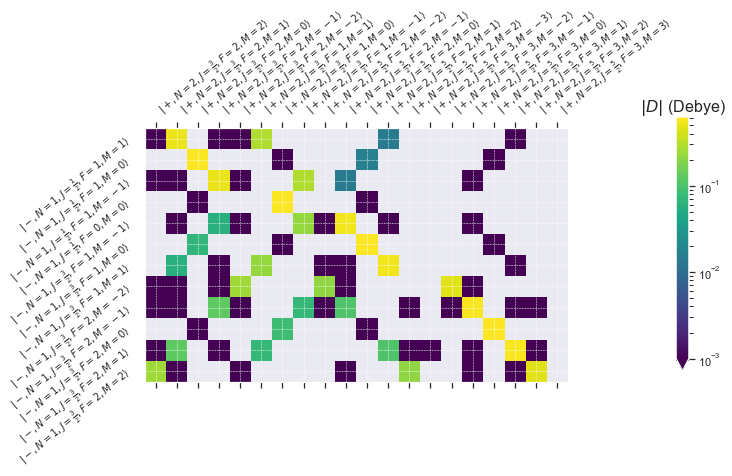

In [18]:
fig,ax = plt.subplots(figsize=(10,10),constrained_layout=True)
# ax.set_aspect('equal')
N1_all = X010.select_q({'N':1},parity='-')
N2_all = X010.select_q({'N':2},parity='+')
N1s = l2s(N1_all)[0]
N2s = l2s(N2_all)[0]
N1 = np.arange(*N1s)
N2 = np.arange(*N2s)
log=False
BR_plot = abs(TDM0)
BR_plot[BR_plot<1e-8]=0
if log:
    BR_plot=np.log10(BR_plot)
    vmin = -10
    vmax = 0
else:
    vmin=None
    vmax = None
#     log_BR = np.copy(BR0)
#     for i,val1 in enumerate(log_BR):
#         for j,val2 in enumerate(val1):
#             if val2 !=0:
#                 log_BR[i,j] = np.log10(val2)
#     BR_plot = log_BR
mat = ax.matshow(BR_plot[slice(*N1s),slice(*N2s)],cmap=sns.color_palette("viridis", as_cmap=True),norm=colors.LogNorm(vmin=1e-3))#vmax = vmax, vmin = -3)
x = np.arange(0,len(N2))
y = np.arange(0,len(N1))
ax.set_yticks(y)
ax.set_xticks(x)
x_labels = [X010.gen_state_str(i,thresh=0.2,single=True,parity=True,show_coeff=False, label_q=['N','J','F','M']) for i in N2]
y_labels = [X010.gen_state_str(i,thresh=0.2,single=True,parity=True,show_coeff=False, label_q=['N','J','F','M']) for i in N1]
# x_labels = [X010.gen_state_str(i,thresh=0.3,single=True,parity=False,show_coeff=True, basis='decoupled',label_q=['K','M_N','M_S','M_F'],round=2) for i in N2]
# y_labels = [X010.gen_state_str(i,thresh=0.3,single=True,parity=False,show_coeff=True, basis='decoupled',label_q=['K','M_N','M_S','M_F'],round=2) for i in N1]
ax.set_yticklabels(y_labels, rotation='40', fontsize=12, ha='right')
ax.set_xticklabels(x_labels, rotation='40', fontsize=12,ha='left')
ax.tick_params(axis='both',labelsize=10,direction='out')
ax.grid(True,which='major',color='white',ls='--',linewidth=0.5)
ax.grid(False,which='minor')
(bot,top) = ax.get_ylim()
# ax.set_ylim(bot+0.5, top)
cbar = fig.colorbar(mat, ax=ax,fraction=0.03, pad=0.0,extend='min')
cbar.ax.set_title(label=r'$|D|$ (Debye)',size=16,rotation=0)
#ax.set_xlim(-0.5,x.size+0.5);

In [13]:
from tabulate import tabulate

In [135]:
plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X010.evals_B.T[N2]):
    plt.plot(Bz,trace)
plt.xlabel('B (G)',fontsize=14)
plt.ylabel('Energy (MHz)',fontsize=14)
plt.title(r'$^{40}$CaOH $\tilde{X}(010)$ Zeeman Shifts, $N=2-$',fontsize=16);
plt.ylim(49865,49885)

plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X010.evals_E.T[N1]):
    grad = np.gradient(trace)/(Ez[1]-Ez[0])
    plt.plot(Bz,grad)
plt.xlabel('B (G)',fontsize=14)
plt.ylabel('Polarization (MHz/Volts)',fontsize=14)
plt.title(r'$^{40}$CaOH $\tilde{X}(010)$ Magnetization, $N=2-$',fontsize=16);

AttributeError: 'NoneType' object has no attribute 'T'

<Figure size 720x504 with 0 Axes>

(9900.0, 10090.0)

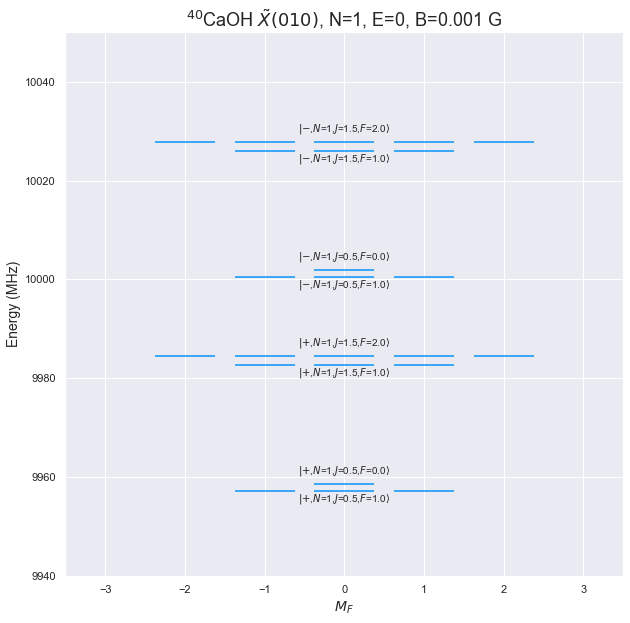

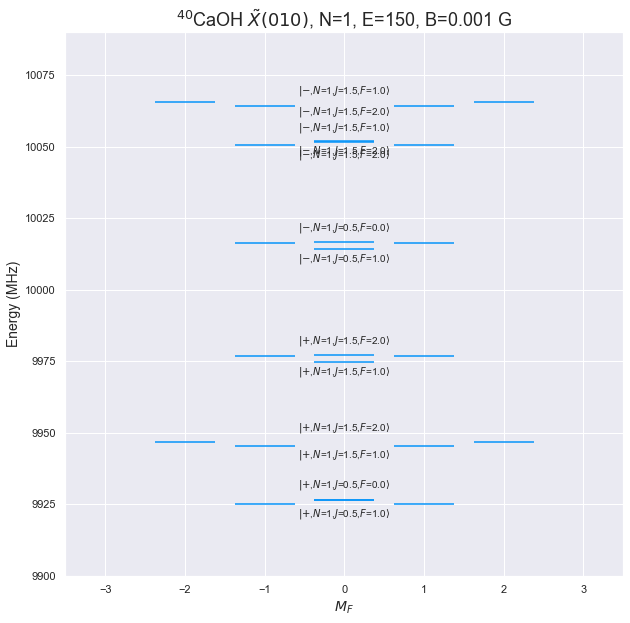

In [57]:
E0=0
B0=1e-3
N=1
X010.display_levels(E0,B0,'F',idx=N_idx[N-1],parity=True,label_q=[q for q in X010.q_str if q!='K'],figsize=(10,10),alt_label=True)
plt.title(X010.state_str+', N={}, E={}, B={} G'.format(N,E0,B0),fontsize=18)
plt.xlim(-3.5,3.5)
plt.ylim(9940,10050)

E0=150
B0=1e-3
N=1
X010.display_levels(E0,B0,'F',idx=N_idx[N-1],parity=True,label_q=[q for q in X010.q_str if q!='K'],figsize=(10,10),alt_label=True)
plt.title(X010.state_str+', N={}, E={}, B={} G'.format(N,E0,B0),fontsize=18)
plt.xlim(-3.5,3.5)
plt.ylim(9900,10090)

# N=2
# X010.display_levels(E0,B0,'F',idx=N_idx[N-1],parity=True,label_q=[q for q in X010.q_str if q!='K'],figsize=(10,10),alt_label=True)
# plt.title(X010.state_str+', N={}, E={} V/cm, B={} G'.format(N,E0,B0),fontsize=18)
# plt.xlim(-3.5,3.5)

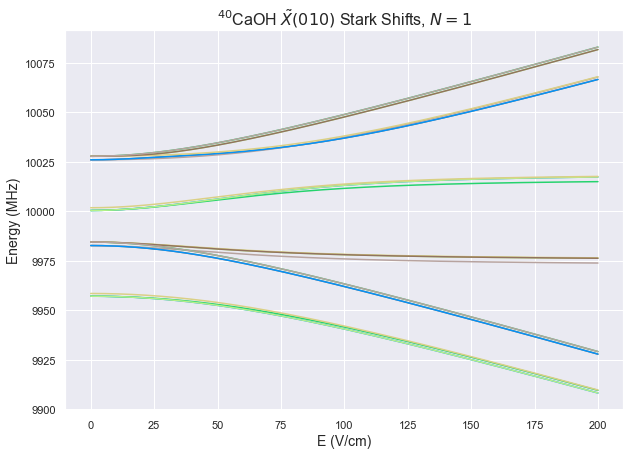

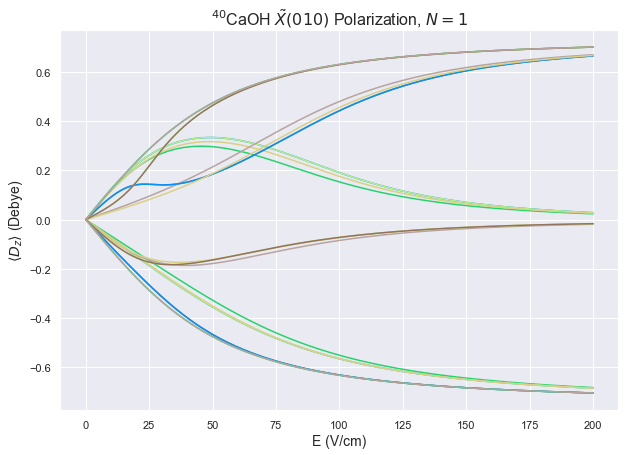

In [133]:
plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X010.evals_E.T[N_idx[0]]):
    plt.plot(Ez,trace)
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('Energy (MHz)',fontsize=14)
plt.title(r'$^{40}$CaOH $\tilde{X}(010)$ Stark Shifts, $N=1$',fontsize=16);

plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X010.evals_E.T[N_idx[0]]):
    grad = np.gradient(trace)/(Ez[1]-Ez[0])
    plt.plot(Ez,grad*1.986)
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel(r'$\langle D_z \rangle$ (Debye)',fontsize=14)
plt.title(r'$^{40}$CaOH $\tilde{X}(010)$ Polarization, $N=1$',fontsize=16);

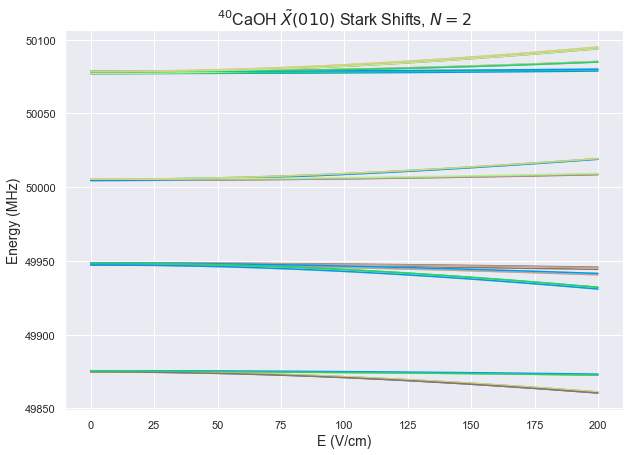

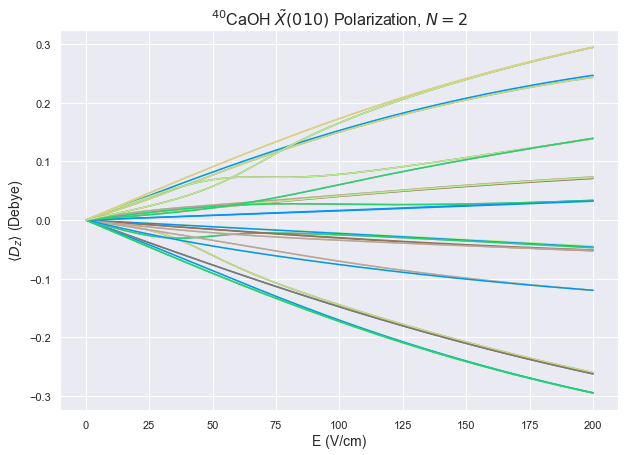

In [134]:
plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X010.evals_E.T[N_idx[1]]):
    plt.plot(Ez,trace)
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('Energy (MHz)',fontsize=14)
plt.title(r'$^{40}$CaOH $\tilde{X}(010)$ Stark Shifts, $N=2$',fontsize=16);

plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X010.evals_E.T[N_idx[1]]):
    grad = np.gradient(trace)/(Ez[1]-Ez[0])
    plt.plot(Ez,grad*1.986)
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel(r'$\langle D_z \rangle$ (Debye)',fontsize=14)
plt.title(r'$^{40}$CaOH $\tilde{X}(010)$ Polarization, $N=2$',fontsize=16);

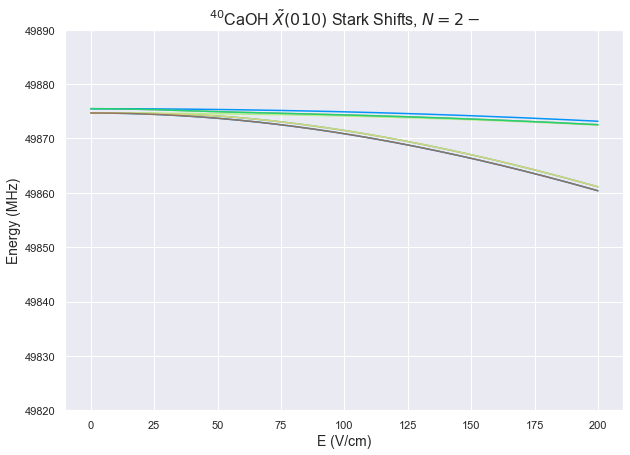

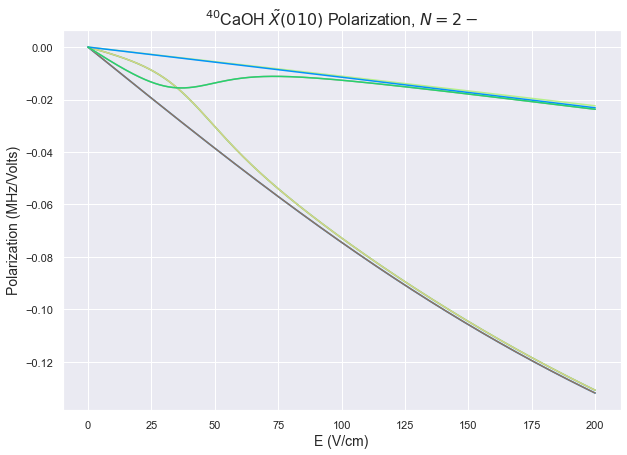

In [135]:
plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X010.evals_E.T[N2_all]):
    plt.plot(Ez,trace)
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('Energy (MHz)',fontsize=14)
plt.title(r'$^{40}$CaOH $\tilde{X}(010)$ Stark Shifts, $N=2-$',fontsize=16);
plt.ylim(49820,49890)

plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X010.evals_E.T[N2_all]):
    grad = np.gradient(trace)/(Ez[1]-Ez[0])
    plt.plot(Ez,grad)
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('Polarization (MHz/Volts)',fontsize=14)
plt.title(r'$^{40}$CaOH $\tilde{X}(010)$ Polarization, $N=2-$',fontsize=16);

In [36]:
X010.display_levels(0,1e-6,'F',idx=N1_all,label_q=[q for q in X010.q_str if q!='K'],alt_label=True)
plt.title(X010.state_str+', N=1d',fontsize=18)

Text(0.5, 1.0, '$^{40}$CaOH $\\tilde{X}(010)$, N=1,2, Free Field')

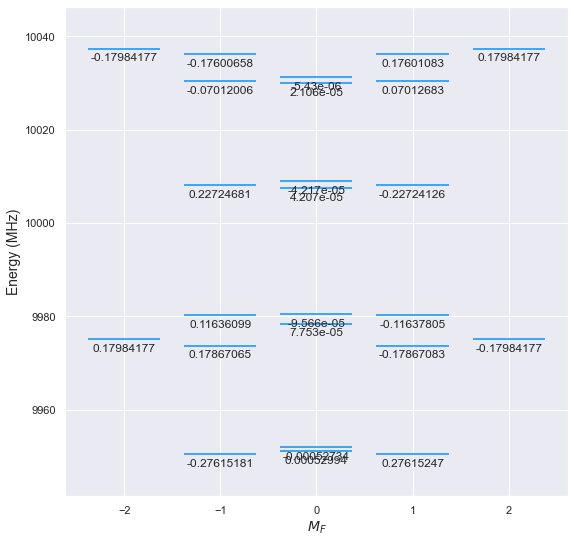

In [130]:
# X010 = MoleculeLevels.initialize_state('CaOH','40','X010',N_list,M_values = 'custom',I=[0,1/2],S=1/2,round=16,M_range=[1])
X010 = MoleculeLevels.initialize_state('CaOH','40','X010',[1],M_values = 'all',I=[0,1/2],S=1/2,round=8)
X010.display_PTV(60.8,1e-3,'EDM')

Text(0.5, 1.0, '$^{40}$CaOH $\\tilde{X}(010)$, N=1,2 60 V/cm, 1e-06 G')

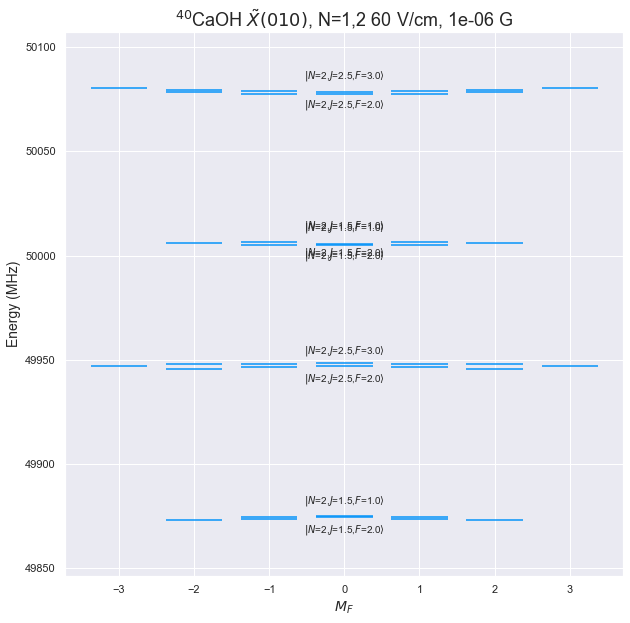

In [14]:
Efield = 60
Bfield = 1e-6
X010.display_levels(Efield,Bfield,'F',idx=N2,label_q=[q for q in X010.q_str if q!='K'],alt_label=True)
plt.title(X010.state_str+', N=1,2 {} V/cm, {} G'.format(Efield,Bfield),fontsize=18)

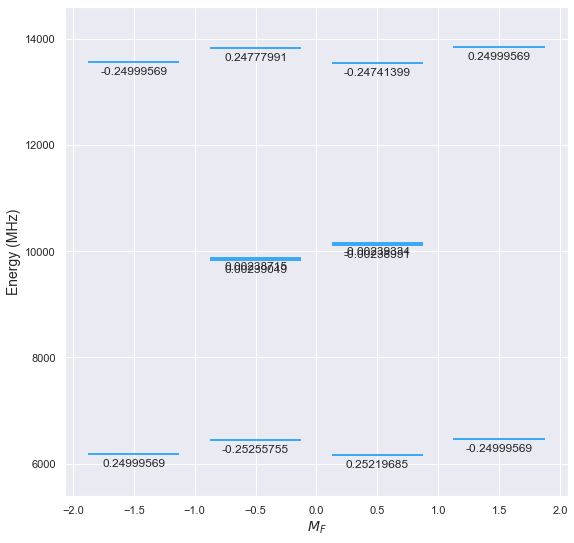

In [41]:
X010.display_PTV(,'EDM')

In [34]:
evals, evecs = X010.eigensystem(Efield,Bfield,order=True,method='torch')
M0_idx = X010.select_q({'M':[-3/2,-1/2,1/2,3/2]})
print(M0_idx)
print('\n')
for i in M0_idx:
    display(Latex('$E = '+str(np.round(X010.evals0[i],4))+r'\:\mathrm{MHz}$'))
    print('Decoupled:')
    display(Latex(X010.gen_state_str(i,basis='decoupled',thresh=0.05,label_q=['K','M_N','M_S','M_I','M_F'],round=4)))
    print('Case A:')
    display(Latex(X010.gen_state_str(i,basis='aBJ',thresh=0.05,label_q=['K','J','F','Sigma','P','M'],round=4)))
    print('Case B:')
    display(Latex(X010.gen_state_str(i,thresh=0.05,round=4)))
    print('\n')

[ 0  1  2  3  4  5  6  7  8  9 10 11]




<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

In [117]:
evals, evecs = X010.eigensystem(1000,1e-8,order=True,method='torch')
M0_idx = X010.select_q({'M':[0]})
print(M0_idx)
print('\n')
for i in M0_idx:
    display(Latex('$E = '+str(np.round(X010.evals0[i],4))+r'\:\mathrm{MHz}$'))
    print('Decoupled:')
    display(Latex(X010.gen_state_str(i,basis='decoupled',thresh=0.01,label_q=['K','M_N','M_S','M_I','M_F'],round=4)))
    print('Case A:')
    display(Latex(X010.gen_state_str(i,basis='aBJ',thresh=0.01,label_q=['J','K','Sigma','P','M'],round=4)))
    print('Case B:')
    display(Latex(X010.gen_state_str(i,thresh=0.01,round=4)))
    print('\n')

[ 2  3  8 11 12 15 18 19]




<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

In [42]:
Bz = np.linspace(1e-6,40,1000)
Ez = np.linspace(0,500,1000)

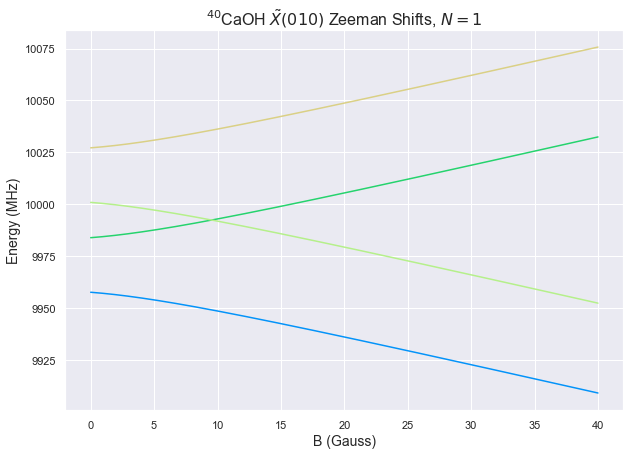

In [75]:
X010.ZeemanMap(Bz,0,plot=True)

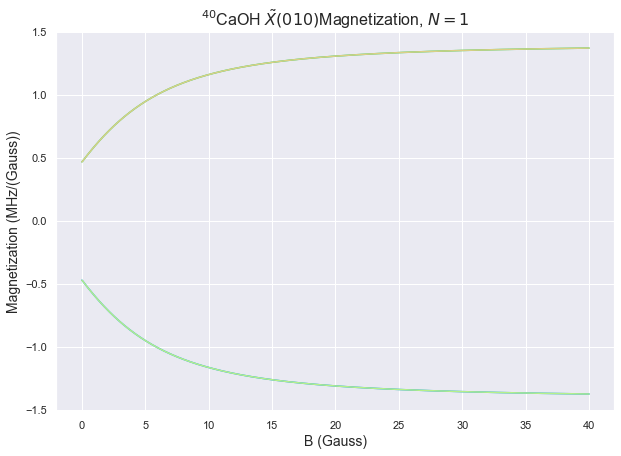

In [76]:
plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X010.evals_B.T):
    grad = np.gradient(trace)/(Bz[1]-Bz[0])
    plt.plot(Bz,grad)
plt.xlabel('B (Gauss)',fontsize=14)
plt.ylabel('Magnetization (MHz/(Gauss))',fontsize=14)
plt.title(X010.state_str + r'Magnetization, $N={}$'.format(*X010.N_range),fontsize=16);

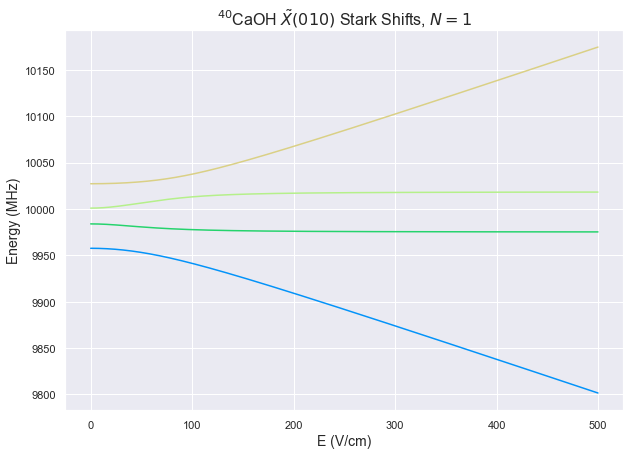

In [78]:
X010.StarkMap(Ez,1e-6,plot=True)
# X010.plot_evals_EB('E',kV_kG=True,GHz=True)

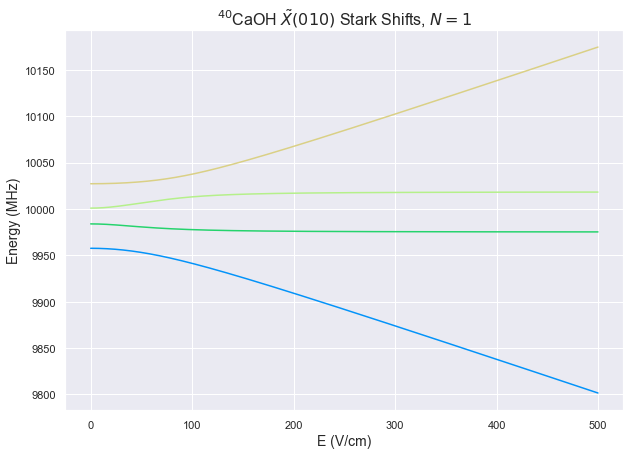

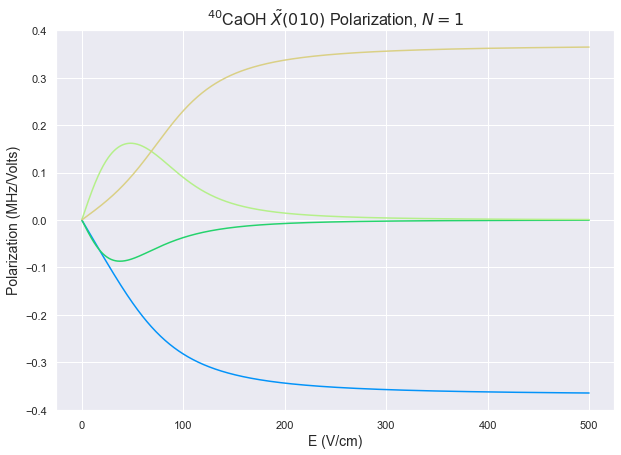

In [98]:
plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X010.evals_E.T):
    plt.plot(Ez,trace)
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('Energy (MHz)',fontsize=14)
plt.title(r'$^{40}$CaOH $\tilde{X}(010)$ Stark Shifts, $N=1$',fontsize=16);

plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X010.evals_E.T):
    grad = np.gradient(trace)/(Ez[1]-Ez[0])
    plt.plot(Ez,grad)
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('Polarization (MHz/Volts)',fontsize=14)
plt.title(r'$^{40}$CaOH $\tilde{X}(010)$ Polarization, $N=1$',fontsize=16);

We can display a plot of the energy levels at arbitray field. (The code does not handle parity labeling well, so I am leaving out L for zero field.)

Text(0.5, 1.0, '$^{40}$CaOH $\\tilde{X}(010)$, N=1, 0.5 kV/cm')

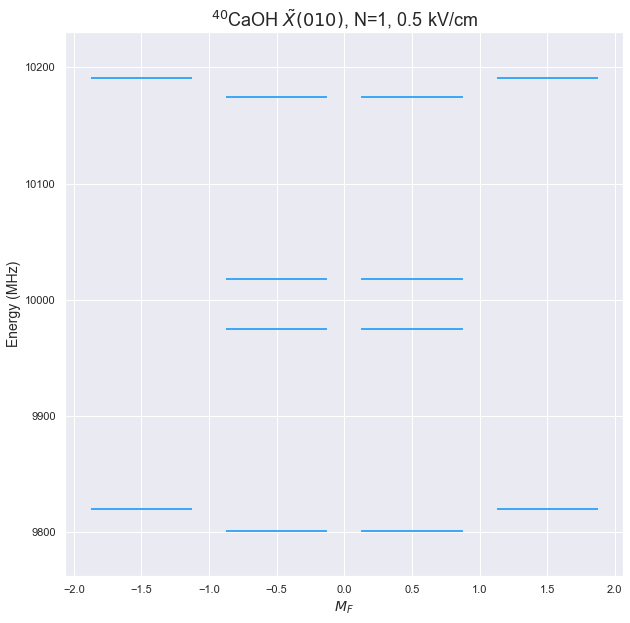

In [47]:
X010.display_levels(500,1e-7,'F',label=None,alt_label=True)
plt.title(X010.state_str+', N=1, 0.5 kV/cm',fontsize=18)

We can also look at PT violating shifts. Here, we consider the EDM shifts as a function of E field. 

In [48]:
X010.eigensystem(0,1e-8);

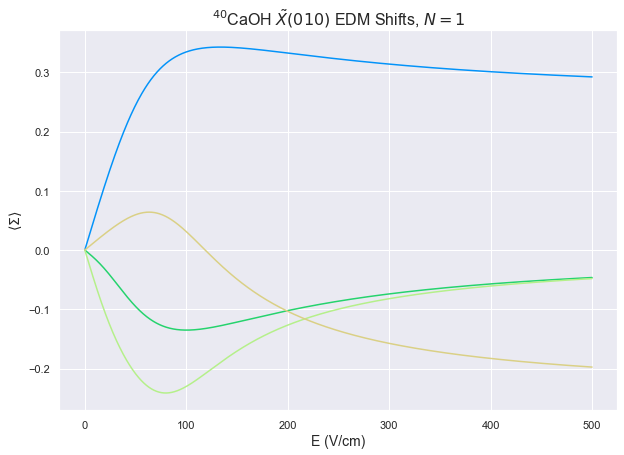

In [85]:
X010.PTV_Map('EDM',E_or_B='E',plot=True)

We can look specifically at the upper and lower Stark manifolds at a given field value too.

Text(0.5, 1.0, '$^{40}$CaOH $\\tilde{X}(010)$, EDM shifts at 60.8 V/cm')

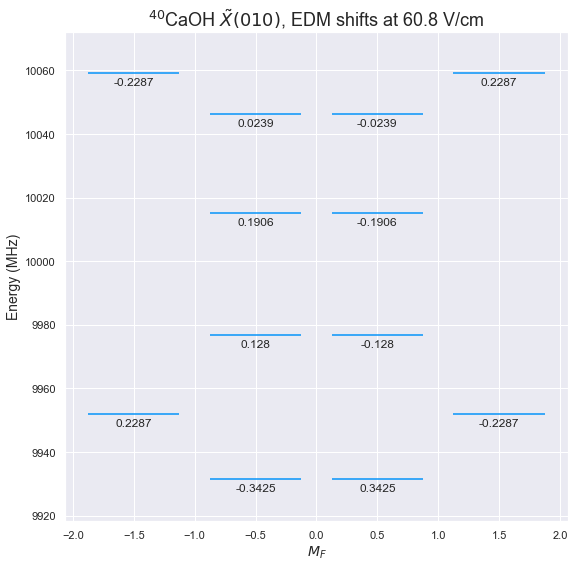

In [51]:
X010.display_PTV(133,1e-7,'EDM',round=4)
plt.title(X010.state_str+', EDM shifts at 60.8 V/cm',fontsize=18)

In [60]:
X010.eigensystem(1000,0)
M0_idx = X010.select_q({'M':[1]})
print(M0_idx)
print('\n')
for i in M0_idx:
    display(Latex('$E = '+str(np.round(X010.evals0[i],4))+r'\:\mathrm{MHz}$'))
    print('Decoupled:')
    display(Latex(X010.gen_state_str(i,basis='decoupled',thresh=0.01,label_q=['K','M_N','M_S','M_I','M_F'],round=4)))
    print('Case A:')
    display(Latex(X010.gen_state_str(i,basis='aBJ',thresh=0.01,label_q=['K','Sigma','P','M'],round=4)))
    print('Case B:')
    display(Latex(X010.gen_state_str(i,thresh=0.01,round=4)))
    print('\n')

[0 1 2 3 4 5]




<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

In [50]:
X010.eigensystem(100,1e-2)
(sy.Matrix(X010.evecs0[0]).T*X010.H_symbolic*sy.Matrix(X010.evecs0[0]))[0]

-0.048487643331535*Bz - 0.277154404334809*Ez + 9969.35364112334

In [43]:
(sy.Matrix(X010.evecs0[1]).T*X010.H_symbolic*sy.Matrix(X010.evecs0[1]))[0]

1.28069264538709*Bz - 0.368490639112473*Ez + 9987.63731699745

In [20]:
import matrix_elements_sym as me
from functools import partial
from matrix_elements_sym import decouple_b_even

def H_even_X(q_numbers,params,matrix_elements,symbolic=True,E=0,B=0,M_values='all',precision=5):
    q_str = list(q_numbers)     # Get keys for quantum number dict
    if symbolic:
        Ez,Bz = sy.symbols('E_z B_z')
        size = len(q_numbers[q_str[0]])
        # Need to construct empty matrices to fill with matrix elements
        # Sympy does not like numpy arrays, so convert to list
        H0 = np.zeros((size,size)).tolist()
        V_B = np.zeros((size,size)).tolist()
        V_E = np.zeros((size,size)).tolist()
        #Iz = np.zeros((size,size)).tolist()
        #Sz = np.zeros((size,size)).tolist()
        for i in range(size):
            for j in range(size):
                # State out is LHS of bra ket, state in is RHS
                state_out = {q+'0':q_numbers[q][i] for q in q_str}
                state_in = {q+'1':q_numbers[q][j] for q in q_str}
                q_args = {**state_out,**state_in}
                elements = {term: sy.nsimplify(element(**q_args)) for term, element in matrix_elements.items()}
                # The Hamiltonian
                H0[i][j] = params['Be']*elements['N^2'] + params['Gamma_SR']*elements['N.S'] + \
                    params['bF']*elements['I.S'] + params['c']/3*sy.sqrt(6)*elements['T2_0(I,S)']
                if params.get('q_lD') is not None:
                    H0[i][j] += params['q_lD']/2*elements['l-doubling'] - params['Gamma_SR']*elements['NzSz']+params['Gamma_Prime']*elements['NzSz']
                if M_values!='none':
                    V_B[i][j]+=params['g_S']*params['mu_B']*elements['ZeemanZ']
                    V_E[i][j]+=-params['muE']*elements['StarkZ']
                # H[i][j] = round(H[i][j],precision)
                #Iz[i][j] = params['c']*elements['Iz']
                #Sz[i][j] = elements['Sz']
        # Need to construct IzSz term and add to Hamiltonian
        #H=matadd(H,matmult(Iz,Sz))
        # Create symbolic object
        H_symbolic = sy.Matrix(H0)+Ez*sy.Matrix(V_E)+Bz*sy.Matrix(V_B)
#         H0_num = np.array(H0).astype(np.float64)
#         V_E_num = np.array(V_E).astype(np.float64)
#         V_B_num = np.array(V_B).astype(np.float64)
        # Use symbolic object to create function that given E and B values, returns a numpy array
#         H_func = lambda E,B: H0_num + V_E_num*E + V_B_num*B
        # H_func = sy.lambdify((Ez,Bz), H_symbolic, modules='numpy')
        return H_symbolic

def decouple_b(input_qnumbers,output_qnumbers,S=1/2,I=1/2):
    input_keys = list(input_qnumbers)
    output_keys = list(output_qnumbers)
    input_size = len(input_qnumbers[input_keys[0]])
    output_size = len(output_qnumbers[output_keys[0]])
    basis_matrix = np.zeros((output_size,input_size)).tolist()
    for i in range(output_size):
        for j in range(input_size):
            decoupled_qnumbers = {q:output_qnumbers[q][i] for q in output_keys}
            b_qnumbers = {q:input_qnumbers[q][j] for q in input_keys}
            basis_matrix[i][j] = sy.nsimplify(decouple_b_even(decoupled_qnumbers,b_qnumbers,S=S,I=I))
    return basis_matrix
   
    

bBJ_even_X_matrix_elements={
        # Fine Structure
        'N^2': me.Rot_bBJ,                 # N^2 Rotation
        'N.S': me.SR_bBJ,                  # N.S Spin Rotation
        'l-doubling': me.lD_bBJ,           # Effective l doubling
        'NzSz': me.NzSz_bBJ,               # NzSz for bending mode

        # Hydrogen Hyperfine
        'I.S': me.IS_bBJ,                  # I.S Fermi Contact Interaction
        'T2_0(I,S)': me.T2IS_bBJ,          # I S dipolar interaction
        'Iz': me.Iz_bBJ,                   # I.n projection of I on internuclear axis n
        'Sz': me.Sz_bBJ,                   # S.n projection of S on internuclear axis n
        }

ext_fields = {
# External Fields
'ZeemanZ': me.ZeemanZ_bBJ,         # Zeeman interaction with lab z magnetic field
'StarkZ': me.StarkZ_bBJ            # Stark interaction with lab z electric field
}
bBJ_even_X_matrix_elements.update(ext_fields)
for term,element in bBJ_even_X_matrix_elements.items():       #iterate through, substitute hydrogen proton value
            bBJ_even_X_matrix_elements[term] = partial(element,I=1/2)

        

B,gamma,gammap, bF,c,b,q_lD,muE,muB,g_S,g_L = sy.symbols('B_{rot} gamma gamma^\' b_F c b q_{lD} D mu_B g_S g_L')
params_40X010 = {
'Be': B,
'Gamma_SR': gamma,
'Gamma_Prime': gammap,
'bF': 0,
'c': 0,
'b': b,
'q_lD': q_lD,
'muE': muE,
'mu_B': muB, #MHz/Gauss
'g_S': g_S,
'g_L': g_L,
}

def build_operator(q_numbers,parameter,operator_element,M_values='all',precision=5):
    q_str = list(q_numbers)     # Get keys for quantum number dict
    size = len(q_numbers[q_str[0]])
    # Need to construct empty matrices to fill with matrix elements
    # Sympy does not like numpy arrays, so convert to list
    H0 = np.zeros((size,size)).tolist()
    #Iz = np.zeros((size,size)).tolist()
    #Sz = np.zeros((size,size)).tolist()
    for i in range(size):
        for j in range(size):
            # State out is LHS of bra ket, state in is RHS
            state_out = {q+'0':q_numbers[q][i] for q in q_str}
            state_in = {q+'1':q_numbers[q][j] for q in q_str}
            q_args = {**state_out,**state_in}
            operator = sy.nsimplify(operator_element(**q_args))
            H0[i][j]+= parameter*operator
    H_symbolic = sy.Matrix(H0)
    return H_symbolic

In [21]:
H_sym = H_even_X(X010.q_numbers,params_40X010,bBJ_even_X_matrix_elements,symbolic=True,E=0,B=0,M_values='all',precision=8)

In [22]:
(H_sym)

Matrix([
[            B_{rot} - gamma/2 - gamma^'/2,                                   -q_{lD},                                                        0,                                                        0,                 -B_z*g_S*mu_B/6 + D*E_z/3,                                         0,                                                         0,                                                         0,                                                               0,                                                               0, -sqrt(2)*B_z*g_S*mu_B/3 + sqrt(2)*D*E_z/6,                                         0,                                                              0,                                                              0,                                                         0,                                                         0,                                                         0,                                                         0,     

In [23]:
NzSz = build_operator(X010.q_numbers,params_40X010['Gamma_Prime'],bBJ_even_X_matrix_elements['NzSz'],precision=8)
NS = build_operator(X010.q_numbers,params_40X010['Gamma_SR'],bBJ_even_X_matrix_elements['N.S'],precision=8)

In [24]:
NS-NzSz

Matrix([
[-gamma + gamma^'/2,                  0,                  0,                  0,                  0,                  0,                  0,                  0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0],
[                 0, -gamma + gamma^'/2,                  0,                  0,                  0,                  0,                  0,                  0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                  

In [25]:
inputt = X010.q_numbers
output = X010.alt_q_numbers['decoupled']
basis_matrix = sy.Matrix(decouple_b(inputt,output,I=1/2))

In [26]:
H_dcpl = basis_matrix*H_sym*basis_matrix.T

In [27]:
NzSz_dcpl = basis_matrix*NzSz*basis_matrix.T
NS_dcpl = basis_matrix*NS*basis_matrix.T

In [28]:
SR_dcpl = NS_dcpl-NzSz_dcpl

In [29]:
SR_dcpl

Matrix([
[gamma/2 - gamma^'/4,                   0,                   0,                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                                   0,                   0,                   0,                   0,                   0],
[                  0, gamma/2 - gamma^'/4,                   0,                   0,                                   0,                                   0,                                   0,                                  

In [24]:
ilist = range(0,24)
for i in ilist:
    print(i)
    for k,v in X010.alt_q_numbers['decoupled'].items():
        print('{} = {}'.format(k,v[i]))

0
K = -1
N = 1
M_N = -1
M_S = -0.5
M_I = 0
M_F = -1.5
1
K = 1
N = 1
M_N = -1
M_S = -0.5
M_I = 0
M_F = -1.5
2
K = -1
N = 1
M_N = -1
M_S = 0.5
M_I = 0
M_F = -0.5
3
K = 1
N = 1
M_N = -1
M_S = 0.5
M_I = 0
M_F = -0.5
4
K = -1
N = 1
M_N = 0
M_S = -0.5
M_I = 0
M_F = -0.5
5
K = 1
N = 1
M_N = 0
M_S = -0.5
M_I = 0
M_F = -0.5
6
K = -1
N = 1
M_N = 0
M_S = 0.5
M_I = 0
M_F = 0.5
7
K = 1
N = 1
M_N = 0
M_S = 0.5
M_I = 0
M_F = 0.5
8
K = -1
N = 1
M_N = 1
M_S = -0.5
M_I = 0
M_F = 0.5
9
K = 1
N = 1
M_N = 1
M_S = -0.5
M_I = 0
M_F = 0.5
10
K = -1
N = 1
M_N = 1
M_S = 0.5
M_I = 0
M_F = 1.5
11
K = 1
N = 1
M_N = 1
M_S = 0.5
M_I = 0
M_F = 1.5
12


IndexError: list index out of range

In [25]:
vec = np.zeros(24)
vec[6] = 1/sy.sqrt(2) #
vec[17] = 1/sy.sqrt(2)

In [26]:
NS_dcpl-NzSz_dcpl

Matrix([
[gamma/4,       0,               0,               0,               0,               0,               0,               0,               0,               0,       0,       0],
[      0, gamma/4,               0,               0,               0,               0,               0,               0,               0,               0,       0,       0],
[      0,       0,        -gamma/4,               0, sqrt(2)*gamma/4,               0,               0,               0,               0,               0,       0,       0],
[      0,       0,               0,        -gamma/4,               0, sqrt(2)*gamma/4,               0,               0,               0,               0,       0,       0],
[      0,       0, sqrt(2)*gamma/4,               0,               0,               0,               0,               0,               0,               0,       0,       0],
[      0,       0,               0, sqrt(2)*gamma/4,               0,               0,               0,               0, 

In [27]:
H_dcpl=sy.simplify(H_dcpl)
H_dcpl

Matrix([
[-B_z*g_S*mu_B/2 + B_{rot} - D*E_z/2 + gamma/4,                                       -q_{lD},                                            0,                                            0,                         0,                         0,                        0,                        0,                                             0,                                             0,                                            0,                                            0],
[                                      -q_{lD}, -B_z*g_S*mu_B/2 + B_{rot} + D*E_z/2 + gamma/4,                                            0,                                            0,                         0,                         0,                        0,                        0,                                             0,                                             0,                                            0,                                            0],
[                              

In [135]:
X010.eigensystem(1000,0)
even = sy.Matrix([0,1/sy.sqrt(2),0,0,0,0,1/sy.sqrt(2),0])
odd = sy.Matrix([1/sy.sqrt(2),0,0,0,0,0,0,-1/sy.sqrt(2)])
x = sy.simplify(even.T*H_dcpl*even)
y = sy.simplify(odd.T*H_dcpl*odd)
x[0]

B_{rot} + D*E_z/2 + b_F/4 + c/60 - gamma/4

In [136]:
y[0]

B_{rot} - D*E_z/2 + b_F/4 + c/60 - gamma/4

In [142]:
X010.eigensystem(1000,)
x = sy.Matrix(X010.evecs0[0]).T*H_sym*sy.Matrix(X010.evecs0[0])
y = sy.Matrix(X010.evecs0[1]).T*H_sym*sy.Matrix(X010.evecs0[1])
sy.N(x-y)[0]

-1.09823410572936e-11*B_z*g_S*mu_B + 3.74903172901661e-5*D*E_z - 0.00019018948895402*b_F - 0.0122648086400407*c - 5.8647193332706e-5*gamma + 0.00118230125639449*q_{lD}

In [42]:
X010.H_symbolic

Matrix([
[                           9980.21896666667,                                      21.649,         -0.4670780207227*Bz + 0.24583286*Ez,                                           0, -1.32109614318485*Bz + 0.173830082344483*Ez,                                           0,                                           0,                                           0],
[                                     21.649,                            9980.21896666667,                                           0,         -0.4670780207227*Bz - 0.24583286*Ez,                                           0, -1.32109614318485*Bz - 0.173830082344483*Ez,                                           0,                                           0],
[        -0.4670780207227*Bz + 0.24583286*Ez,                                           0,                            9978.89541111111,                                      21.649,                            1.14594510633293,                                          

In [17]:
X010.eigensystem(100000,0)
M0_idx = X010.select_q({'M':[0]})
print(M0_idx)
for i in M0_idx:
    print('E =',X010.evals0[i])
    display(Latex(X010.gen_state_str(i,basis='decoupled',thresh=0.001,label_q=['K','M_N','M_S','M_I','M_F'])))
#     display(Latex(X010.gen_state_str(i,basis='aBJ',thresh=0.05,label_q=['K','Sigma','P','M'])))
#     display(Latex(X010.gen_state_str(i,thresh=0.05)))

[0 1 2 3 4 5 6 7]
E = -26869.87053477218


<IPython.core.display.Latex object>

E = -26869.753213628093


<IPython.core.display.Latex object>

E = 9973.151313958582


<IPython.core.display.Latex object>

E = 10016.449292801037


<IPython.core.display.Latex object>

E = 10042.423225935365


<IPython.core.display.Latex object>

E = 10085.720997939427


<IPython.core.display.Latex object>

E = 46880.36769489169


<IPython.core.display.Latex object>

E = 46880.485222874166


<IPython.core.display.Latex object>

In [83]:
X010.eigensystem(0,1e-6)
X010.g_eff_Map(step=1e-6);

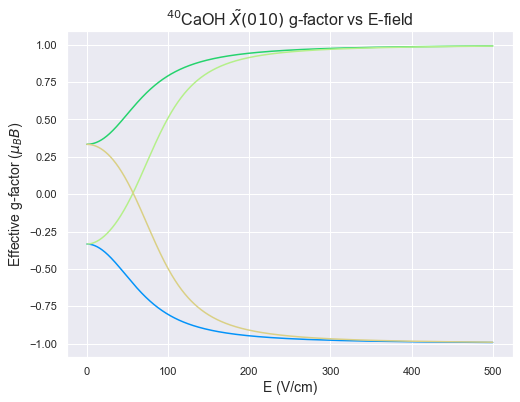

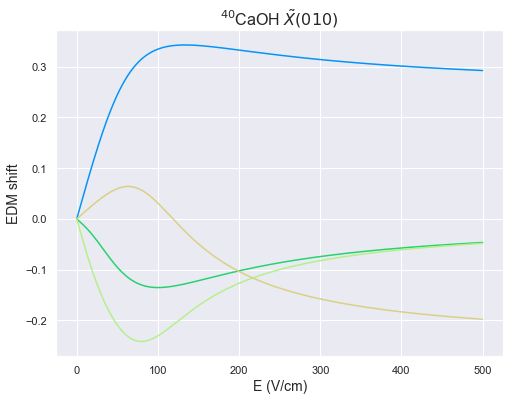

In [86]:
j = range(len(X010.evals0))
plt.figure(figsize=(8,6))
for i in range(len(X010.g_eff_E.T)):#range(len(X010_174.g_eff_E.T)):
    plt.plot(Ez,X010.g_eff_E.T[i])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel(r'Effective g-factor ($\mu_B B$)',fontsize=14)
plt.title(X010.state_str + ' g-factor vs E-field',fontsize=16);
plt.figure(figsize=(8,6))
for i in range(len(X010.g_eff_E.T)):#range(len(X010_174.PTV_E.T)):
    plt.plot(Ez,X010.PTV_E.T[i])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('EDM shift',fontsize=14)
plt.title(X010.state_str,fontsize=16);

In [81]:
X010.eigensystem(0,1e-6)
M_idx = X010.select_q({'M':[1/2]})
print(M_idx)

[0 1 2 3]


IndexError: index 4 is out of bounds for axis 0 with size 4

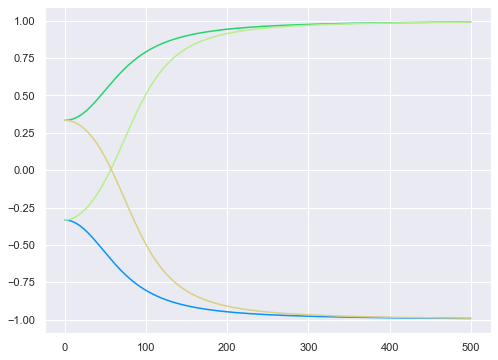

In [87]:
j = range(len(X010.evals0))
plt.figure(figsize=(8,6))
for i in range(10):#range(len(X010_174.g_eff_E.T)):
    plt.plot(Ez,X010.g_eff_E.T[i])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel(r'Effective g-factor ($\mu_B B$)',fontsize=14)
plt.title(X010.state_str + ' g-factor vs E-field',fontsize=16);
plt.xlim(53,73)
plt.figure(figsize=(8,6))
for i in range(12):#range(len(X010_174.PTV_E.T)):
    plt.plot(Ez,X010.PTV_E.T[i])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('EDM shift',fontsize=14)
plt.title(X010.state_str,fontsize=16);
plt.xlim(53,73);

In [175]:
for j in [12,18]:
    g_eff = X010.g_eff_E.T[j]
    for i in range(1,len(g_eff)):
        if (g_eff[i]>0 and g_eff[i-1]<0) or g_eff[i]<0 and g_eff[i-1]>0:
            print('idx =',j)
            print('E field =',(Ez[i]+Ez[i-1])/2)
            print('PTV =,',(X010.PTV_E.T[j][i]+X010.PTV_E.T[j][i-1])/2)
            print('Energy =',(X010.evals_E.T[j][i]+X010.evals_E.T[j][i-1])/2)

idx = 12
E field = 60.83108310831083
PTV =, -0.22727988
Energy = 10008.053070099853
idx = 18
E field = 65.28152815281528
PTV =, 0.070567485
Energy = 10030.921999206803


In [196]:
X010.eigensystem(1000,1e-7)
M_idx = X010.select_q({'M':[0]})
idx = M_idx
for i in idx:
    print(idx)
    print(X010.g_eff_EB()[i])
    display(Latex('$E = '+str(np.round(X010.evals0[i],4))+r'\:\mathrm{MHz}$'))
    print('Decoupled:')
    display(Latex(X010.gen_state_str(i,basis='decoupled',thresh=0.05,label_q=['K','M_N','M_S','M_I','M_F'],round=4)))
    print('Case A:')
    display(Latex(X010.gen_state_str(i,basis='aBJ',thresh=0.05,label_q=['J','K','Sigma','P','M'],round=4)))
    print('Case B:')
    display(Latex(X010.gen_state_str(i,thresh=0.05,round=4)))
    print('\n')

[ 2  3  8 11 12 15 18 19]
3.8988801882439546e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>



[ 2  3  8 11 12 15 18 19]
7.797760376487909e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>



[ 2  3  8 11 12 15 18 19]
-1.2996267294146515e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>



[ 2  3  8 11 12 15 18 19]
-2.599253458829303e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>



[ 2  3  8 11 12 15 18 19]
-1.2996267294146515e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>



[ 2  3  8 11 12 15 18 19]
-3.8988801882439546e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>



[ 2  3  8 11 12 15 18 19]
-2.599253458829303e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>



[ 2  3  8 11 12 15 18 19]
1.2996267294146515e-05


<IPython.core.display.Latex object>

Decoupled:


<IPython.core.display.Latex object>

Case A:


<IPython.core.display.Latex object>

Case B:


<IPython.core.display.Latex object>

Text(0.5, 1.0, '$^{40}$CaOH $\\tilde{X}(010)$, EDM shifts at 65.28 V/cm')

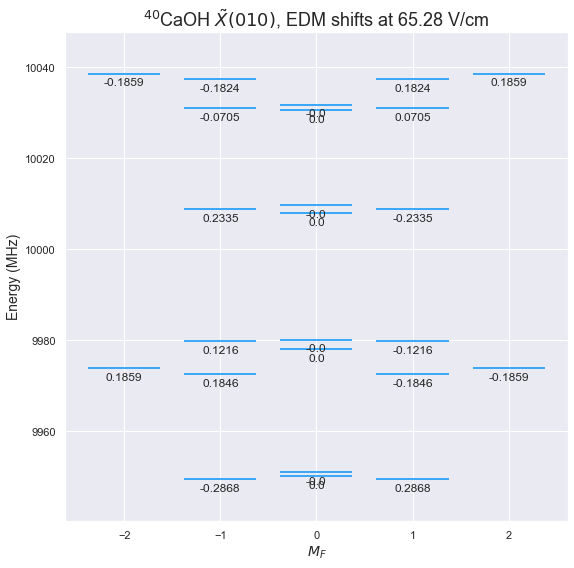

In [179]:
X010.display_PTV(65.28,1e-7,'EDM',round=4)
plt.title(X010.state_str+', EDM shifts at 65.28 V/cm',fontsize=18)

[ 1  3  5  9 13 15 17 21]
1 1.45e-05 499.7999799979998
3 1.45e-05 499.74997499749975
5 1.3e-07 105.06050605060506
9 1.3e-07 90.65906590659066
13 1.6e-07 105.71057105710571
15 1.8e-07 106.66066606660665
17 1.149e-05 499.8999899989999
21 1.149e-05 499.84998499849985


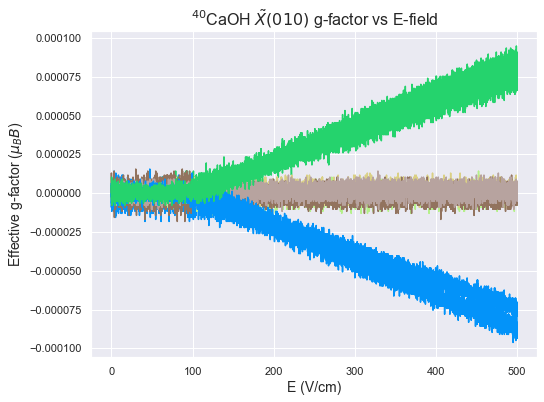

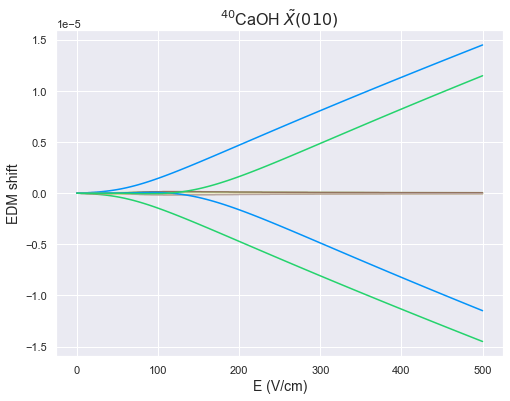

In [192]:
X010.eigensystem(0,1e-6)
M_idx = X010.select_q({'M':[0]})
print(M_idx)

j = range(len(X010.evals0))
plt.figure(figsize=(8,6))
for i in M_idx:#range(len(X010_174.g_eff_E.T)):
    plt.plot(Ez,X010.g_eff_E.T[i])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel(r'Effective g-factor ($\mu_B B$)',fontsize=14)
plt.title(X010.state_str + ' g-factor vs E-field',fontsize=16);
plt.figure(figsize=(8,6))
for i in M_idx:#range(len(X010_174.PTV_E.T)):
    plt.plot(Ez,X010.PTV_E.T[i])
    print(i,max(abs(X010.PTV_E.T[i])),Ez[np.argmax(abs(X010.PTV_E.T[i]))])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('EDM shift',fontsize=14)
plt.title(X010.state_str,fontsize=16);

Text(0.5, 1.0, '$^{40}$CaOH $\\tilde{X}(010)$, EDM shifts at 1000 V/cm and 10 mG')

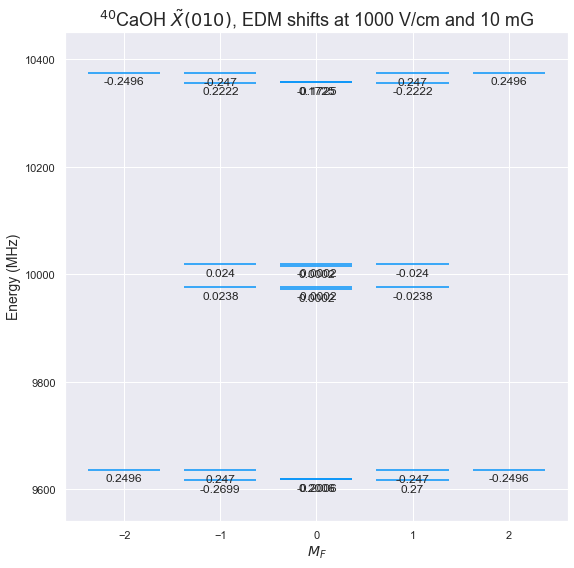

In [199]:
X010.display_PTV(1000,1e-2,'EDM',round=4)
plt.title(X010.state_str+', EDM shifts at 1000 V/cm and 10 mG',fontsize=18)

In [105]:
import time
X010_p = MoleculeLevels.initialize_state('CaOH','40','X010',N_list,M_values = 'custom',I=[0,1/2],S=1/2,round=8,M_range=[1])

Bz = np.linspace(1e-6,20,1000)
Ez = np.linspace(0,500,1000)
t0 = time.perf_counter()
Bslices_p = X010_p.EB_grid(Ez,Bz,PTV=True,E_or_B_first='B',output=True,EDM_or_MQM='EDM')
t1 = time.perf_counter()
elapsed = t1 - t0
print(elapsed, 'sec')

25.03476210000008 sec


In [49]:
import json
import ujson as uj

def get_json_data(file_path,numpy=False,ujson=True):
    if '.json' not in file_path:
        file_path+='.json'
    with open(file_path, 'r') as f:
        if ujson:
            data = uj.load(f)
        else:
            data = json.load(f)
    if numpy:
        data = np.array(data)
    return data

def save_json_data(data,file_path,ujson=True):
    if type(data) is np.ndarray:
        data_save = data.tolist()
    else:
        data_save=data
    if '.json' not in file_path:
        file_path+='.json'
    with open(file_path,'w') as f:
        if ujson:
            uj.dump(data_save,f)
        else:
            json.dump(data_save,f)
    print('Data saved to', file_path)

In [50]:
# save_json_data(Bslices[0].tolist(),'X010_CaOH_Mpm0p5_EB_grid_evals_20220306')
# save_json_data(Bslices[1].tolist(),'X010_CaOH_Mpm0p5_EB_grid_PTV_20220306')

In [106]:
mesh = np.array(np.meshgrid(Ez,Bz,indexing='ij'))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  """


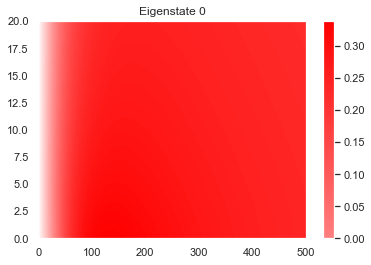

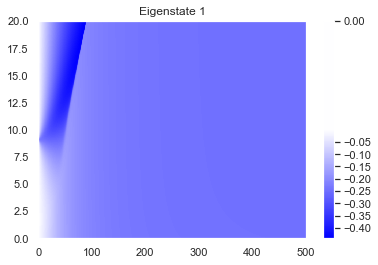

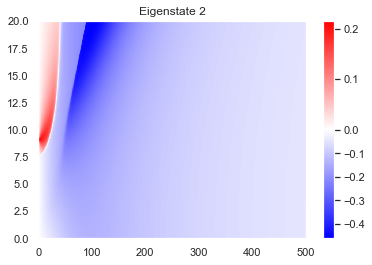

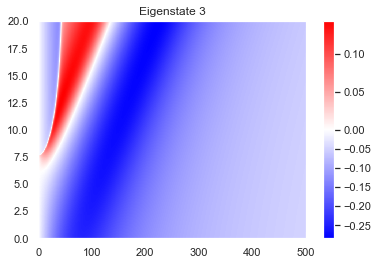

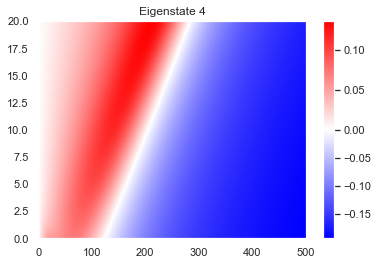

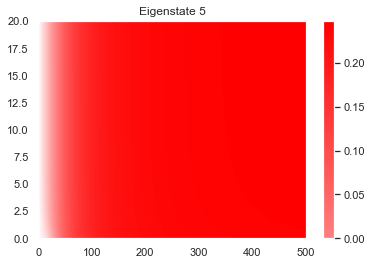

In [107]:
from matplotlib.colors import TwoSlopeNorm
for i in range(len(Bslices_p[0])):
    plt.figure()
    plt.pcolormesh(*mesh,Bslices_p[1][i],shading='auto',cmap='bwr',norm=TwoSlopeNorm(0))
    plt.colorbar()
    plt.title('Eigenstate {}'.format(i))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


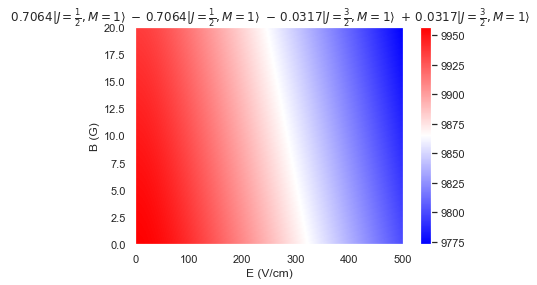

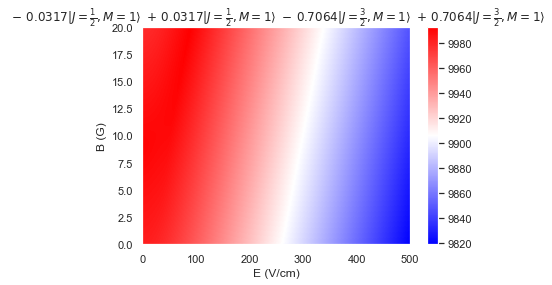

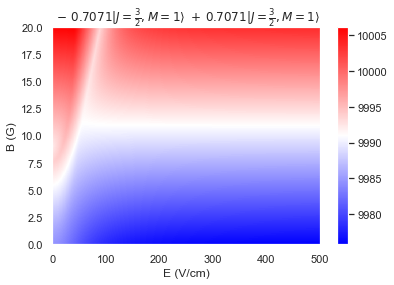

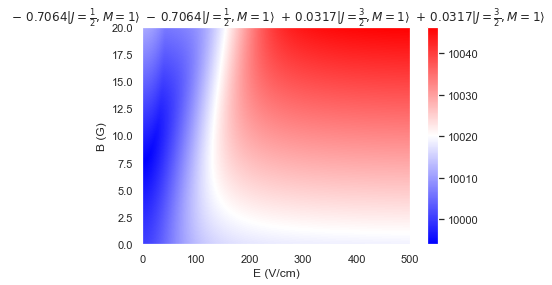

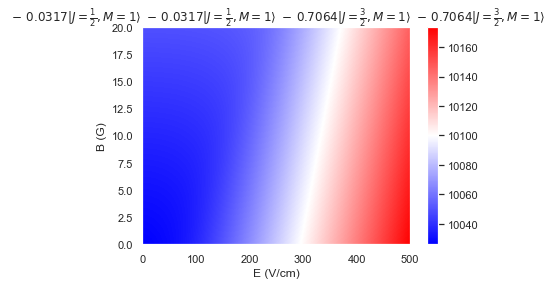

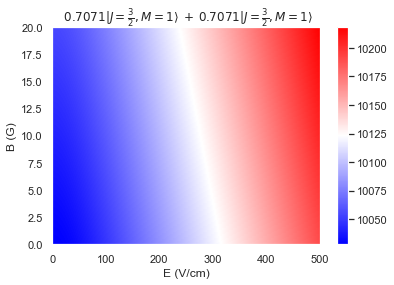

In [108]:
mesh = np.array(np.meshgrid(Ez,Bz,indexing='ij'))
for i in range(len(Bslices_p[0])):
    plt.figure()
    plt.grid(False)
    plt.pcolormesh(*mesh,Bslices_p[0][i],shading='auto',cmap='bwr')
    plt.colorbar()
    plt.title(X010_p.gen_state_str(i,round=4,label_q=['J','M']))
    plt.xlabel('E (V/cm)')
    plt.ylabel('B (G)')

In [73]:
np.gradient(Bslices_p[0][0])[1]/(Bz[1]-Bz[0])

array([[-5355728.85423, -2678181.5899 , -1339206.26323, ...,
           -7655.38735,    -7654.93535,    -7654.7095 ],
       [-5355531.53913, -2678082.64793, -1339156.52261, ...,
           -7655.38253,    -7654.93054,    -7654.70469],
       [-5354934.98431, -2677784.10418, -1339007.56767, ...,
           -7655.36806,    -7654.91609,    -7654.69025],
       ...,
       [  -30677.45953,   -17459.08086,   -10543.94911, ...,
           -7165.79655,    -7165.78812,    -7165.7839 ],
       [  -30660.62245,   -17451.45616,   -10540.68135, ...,
           -7165.76865,    -7165.76022,    -7165.75601],
       [  -30643.80722,   -17443.84186,   -10537.41838, ...,
           -7165.74078,    -7165.73236,    -7165.72816]])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  import sys


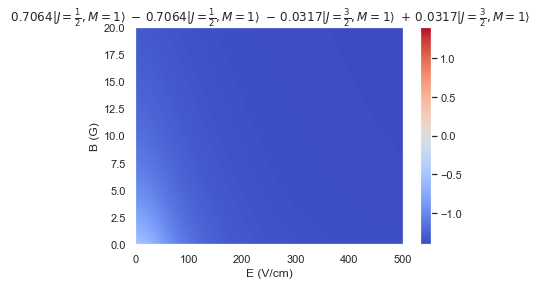

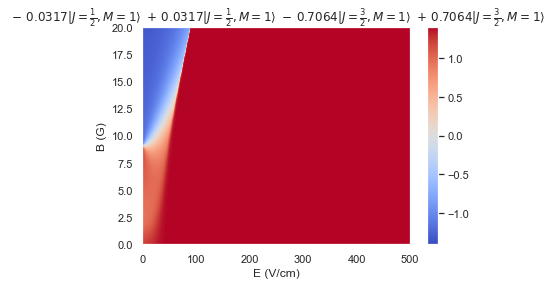

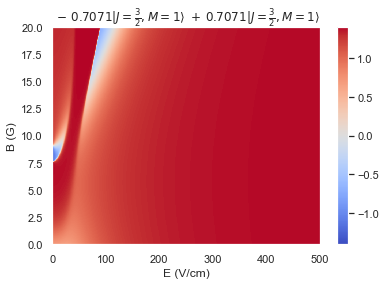

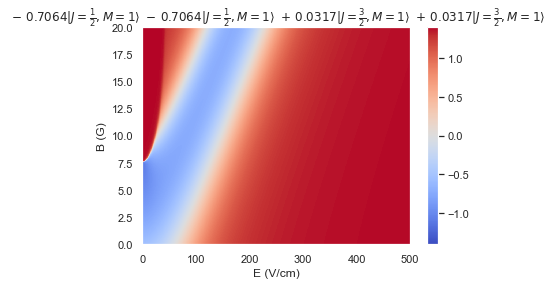

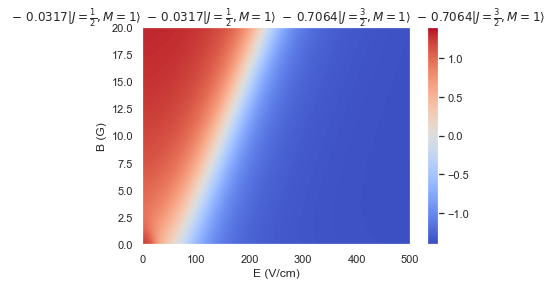

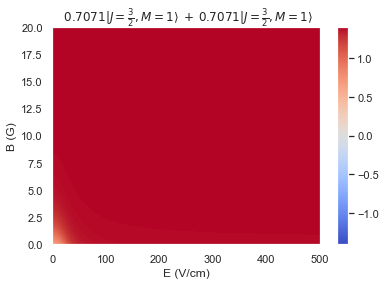

In [109]:
mesh = np.array(np.meshgrid(Ez,Bz,indexing='ij'))
for i in range(len(Bslices_p[0])):
    geff = np.gradient(Bslices_p[0][i])[1]/(Bz[1]-Bz[0])
    plt.figure()
    plt.grid(False)
    plt.pcolormesh(*mesh,geff,shading='auto',cmap='coolwarm',vmin=-1.4,vmax=1.4)
    plt.colorbar()
    plt.title(X010_p.gen_state_str(i,round=4,label_q=['J','M']))
    plt.xlabel('E (V/cm)')
    plt.ylabel('B (G)')

In [97]:
np.log10(-0.01)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


nan

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  import sys


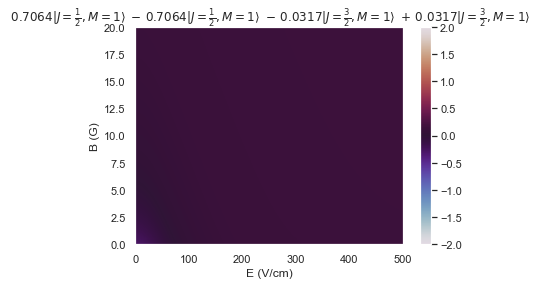

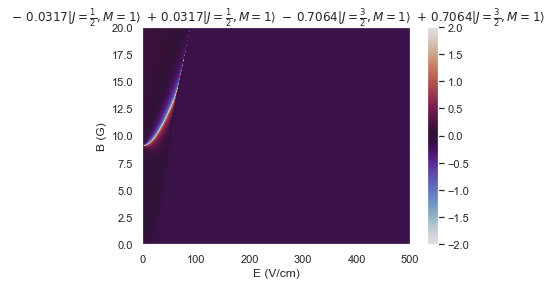

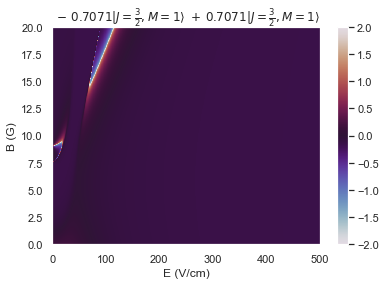

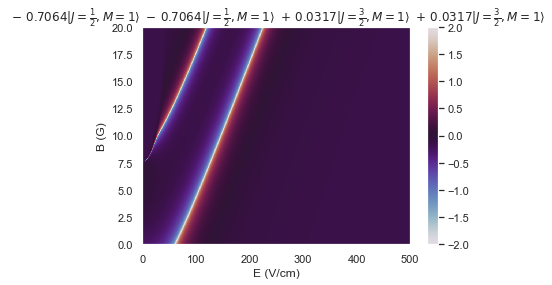

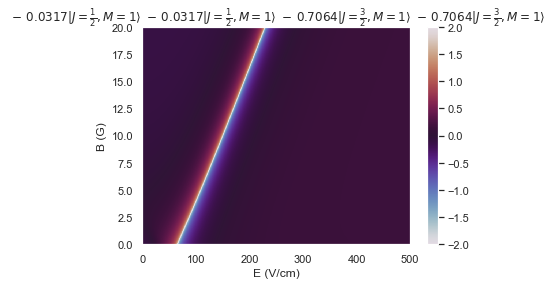

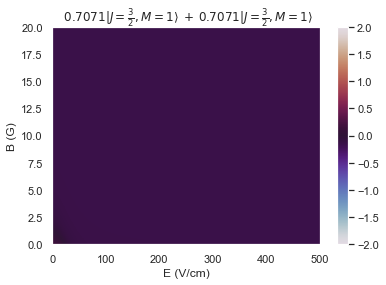

In [110]:
mesh = np.array(np.meshgrid(Ez,Bz,indexing='ij'))
for i in range(len(Bslices_p[0])):
    geff = np.gradient(Bslices_p[0][i])[1]/(Bz[1]-Bz[0])
    plt.figure()
    plt.grid(False)
    plt.pcolormesh(*mesh,-np.sign(geff)*np.log10(abs(geff)),shading='auto',cmap='twilight',vmin=-2,vmax=2)
    plt.colorbar()
    plt.title(X010_p.gen_state_str(i,round=4,label_q=['J','M']))
    plt.xlabel('E (V/cm)')
    plt.ylabel('B (G)')